# Manual parallelism with `shard_map`

<!--* freshness: { reviewed: '2024-04-08' } *-->

## Overview

`shard_map` is a single-program multiple-data (SPMD) multi-device parallelism API to map a function over shards of data. Mapped function applications, or _instances_, communicate with each other via explicit collective communication operations.

`shard_map` is complementary to, and composable with, the automatic compiler-based parallelization built into `jit`. With `jit` you write code as if for a single device, and [the compiler can automatically partition computation over multiple devices](https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html), generating per-device code and communication collectives behind the scenes. With `shard_map` you take control, writing your own partitioned code and explicit collectives. Or you can do a bit of both: take manual control across groups of devices while leaving within-group device partitioning up to the compiler. The two approaches can be mixed, matched, and composed as needed.

If you're familiar with `pmap`, think of `shard_map` as an evolution. It's more expressive, performant, and composable with other JAX APIs. It even works eagerly, for easier debugging! (For more, see [a detailed comparison to `pmap`.](https://docs.jax.dev/en/latest/jep/14273-shard-map.html#why-don-t-pmap-or-xmap-already-solve-this))

By reading this tutorial, you'll learn how to use `shard_map` to get full control over your multi-device code. You'll see in detail how it composes with `jax.jit`'s automatic parallelization and `jax.grad`'s automatic differentiation. We'll also give some basic examples of neural network parallelization strategies.

We'll assume this tutorial is being run in an environment with eight devices:

In [ ]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8' # Use 8 CPU devices

### So, let's see a `shard_map`!

Without further ado, here's a toy example:

In [ ]:
from functools import partial

import jax
import jax.numpy as jnp

from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map

In [ ]:
mesh = jax.make_mesh((4, 2), ('x', 'y'))

a = jnp.arange( 8 * 16.).reshape(8, 16)
b = jnp.arange(16 *  4.).reshape(16, 4)

@partial(shard_map, mesh=mesh, in_specs=(P('x', 'y'), P('y', None)),
         out_specs=P('x', None))
def matmul_basic(a_block, b_block):
  # a_block: f32[2, 8]
  # b_block: f32[8, 4]
  c_partialsum = jnp.dot(a_block, b_block)
  c_block = jax.lax.psum(c_partialsum, 'y')
  # c_block: f32[2, 4]
  return c_block

c = matmul_basic(a, b)   # c: f32[8, 4]

This function computes a matrix multiply in parallel by performing local block matrix multiplies followed by a collective sum operation. We can check the result is correct:

In [ ]:
from jax.tree_util import tree_map, tree_all

def allclose(a, b):
  return tree_all(tree_map(partial(jnp.allclose, atol=1e-2, rtol=1e-2), a, b))

allclose(c, jnp.dot(a, b))

The result is sharded along its rows:

In [ ]:
jax.debug.visualize_array_sharding(c)

At a high level, `shard_map` is kind of like `vmap` or `pmap`, in that we're
mapping a function over pieces of array data, but notice that
* `shard_map` slices up inputs into blocks (and the output is formed by concatenating result blocks), keeping the rank the same, whereas `vmap` would reduce the rank by mapping away an axis;
* the `mesh` argument lets us control precise device placement of computation and results;
* we're mapping over multiple data axes at once, and setting up multiple axis names for collectives (both `'x'` and `'y'` here);
* since we're not using `jax.jit` yet, everything is eagerly evaluated, and we can even `print` intermediate values for debugging.

The above code is performing the same computation as this `jax.jit` automatic parallelization code:

In [ ]:
from jax.sharding import NamedSharding

a = jax.device_put(a, NamedSharding(mesh, P('x', 'y')))
b = jax.device_put(b, NamedSharding(mesh, P('y', None)))

@jax.jit
def matmul_reference(a, b):
  c = jnp.dot(a, b)
  return jax.lax.with_sharding_constraint(c, NamedSharding(mesh, P('x', None)))

c_ref = matmul_reference(a, b)
allclose(c_ref, jnp.dot(a, b))

We can think of `shard_map` as performing a `device_put` or
`with_sharding_constraint` on its inputs according to its `mesh` and `in_specs`
arguments, so the blocks over which `matmul_basic` operates are the same as in
`matmul_reference`:

In [ ]:
print('a blocks:'); jax.debug.visualize_array_sharding(a)
print('b blocks:'); jax.debug.visualize_array_sharding(b)
print('c blocks:'); jax.debug.visualize_array_sharding(c)

### Slow down, start with the basics!

#### Rank-reducing vs rank-preserving maps

We can think of `vmap` and `pmap` as unstacking each array input along an axis
(e.g. unpacking a 2D matrix into its 1D rows), applying its body function to
each piece, and stacking the results back together, at least when collectives
aren't involved:

In [ ]:
def check_vmap(f, xs):
  ans = jax.vmap(f, in_axes=(0,), out_axes=0)(xs)
  expected = jnp.stack([f(x) for x in xs])  # vmap reference semantics
  print(allclose(ans, expected))

check_vmap(lambda x: x @ x, jnp.arange(12).reshape(4, 3))

For example, if `xs` had shape `f32[8,5]` then each `x` would have shape
`f32[5]`, and if each `f(x)` had shape `f32[3,7]` then the final stacked result
`vmap(f)(xs)` would have shape `f32[8,3,7]`. That is, each application of the
body function `f` takes as argument inputs with one fewer axis than the
corresponding argument to `vmap(f)`. We can say these are _rank-reducing maps_
with unstacking/stacking of inputs/outputs.

The number of logical applications of `f`, or _instances_ of `f`, is determined
by the size of the input axis being mapped over: for example, if we map over an
input axis of size 8, semantically we get 8 logical applications of the
function.

In contrast, `shard_map` does not have this rank-reducing behavior. Instead, we
can think of it as slicing (or "unconcatenating") along input axes into blocks,
applying the body function, and concatenating the results back together (again
when collectives aren't involved):

In [ ]:
import numpy as np
devices = np.array(jax.devices()[:4])
mesh = Mesh(devices, ('i',))  # mesh.shape['i'] = 4

def check_shmap(f, y):
  ans = shard_map(f, mesh, in_specs=P('i'), out_specs=P('i'))(y)
  expected = jnp.concatenate([f(y_blk) for y_blk in jnp.split(y, mesh.shape['i'])])
  print(allclose(ans, expected))

check_shmap(lambda x: x.T @ x, jnp.arange(32).reshape(8, 4))

Recall that `jnp.split` slices its input into equally-sized blocks with the same
rank, so that if in the above example `y` had shape `f32[8,5]` then each
`y_blk` would have shape `f32[2,5]`, and if each `f(y_blk)` had shape
`f32[3,7]` then the final concatenated result `shard_map(f, ...)(y)` would have
shape `f32[12,7]`. So `shard_map` maps over _shards_, or blocks, of its inputs.
We can say it's a _rank-preserving map_ with unconcatenating/concatenating of
its inputs/outputs.

The number of logical applications of `f` is determined by the mesh size, not
by any input axis size: for example, if we have a mesh of total size 4 (i.e.
over 4 devices) then semantically we get 4 logical applications of the
function, corresponding to the 4 devices physically computing them.

#### Controlling how each input is split (unconcatenated) and tiled with `in_specs`

Each of the `in_specs` identifies some of the corresponding input array's axes
with mesh axes by name using `PartitionSpec`s, representing how to split (or
unconcatenate) that input into the blocks to which the body function is
applied. That identification determines the shard sizes; when an input axis is
identified with a mesh axis, the input is split (unconcatenated) along that
logical axis into a number of pieces equal to the corresponding mesh axis size.
(It's an error if the corresponding mesh axis size does not evenly divide the
input array axis size.) If an input's pspec does not mention a mesh axis name,
then there's no splitting over that mesh axis. For example:

In [ ]:
mesh = jax.make_mesh((4, 2), ('i', 'j'))

@partial(shard_map, mesh=mesh, in_specs=P('i', None), out_specs=P('i', 'j'))
def f1(x_block):
  print(x_block.shape)  # prints (3, 12)
  return x_block

x1 = jnp.arange(12 * 12).reshape(12, 12)
y = f1(x1)

Here, because the input pspec did not mention the mesh axis name `'j'`, no
input array axis is split over that mesh axis; similarly, because the second
axis of the input array is not identified with (and hence split over) any mesh
axis, application of `f1` gets a full view of the input along that axis.

When a mesh axis is not mentioned in an input pspec, we can always rewrite to a
less efficient program where all mesh axes are mentioned but the caller
performs a `jnp.tile`, for example:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P('i', 'j'))
def f2(x_block):
  print(x_block.shape)
  return x_block

x = jnp.arange(12 * 12).reshape(12, 12)
x_ = jnp.tile(x, (1, mesh.shape['j']))  # x_ has shape (12, 24)
y = f2(x_)  # prints (3,12), and f1(x) == f2(x_)

In other words, because each input pspec can mention each mesh axis name zero
or one times, rather than having to mention each name exactly once, we can say
that in addition to the `jnp.split` built into its input, `shard_map` also has
a `jnp.tile` built into its input, at least logically (though the tiling may
not need to be carried out physically, depending on the arguments' physical
sharding layout). The tiling to use is not unique; we could also have tiled
along the first axis, and used the pspec `P(('j', 'i'), None)`.

Physical data movement is possible on inputs, as each device needs to have a
copy of the appropriate data.

#### Controlling how each output assembled by concatenation, block transposition, and untiling using `out_specs`

Analogously to the input side, each of the `out_specs` identifies some of the
corresponding output array's axes with mesh axes by name, representing how the
output blocks (one for each application of the body function, or equivalently
one for each physical device) should be assembled back together to form the
final output value. For example, in both the `f1` and `f2` examples above the
`out_specs` indicate we should form the final output by concatenating together
the block results along both axes, resulting in both cases an array `y` of
shape `(12, 24)`. (It's an error if an output shape of the body function, i.e.
an output block shape, has a rank too small for the concatenation described by
the corresponding output pspec.)

When a mesh axis name is not mentioned in an output pspec, it represents an
un-tiling: when the user writes an output pspec which does not mention one of
the mesh axis names, they promise that the output blocks are equal along that
mesh axis, and so only one block along that axis is used in the output (rather
than concatenating all the blocks together along that mesh axis). For example,
using the same mesh as above:

In [ ]:
x = jnp.array([[3.]])

z = shard_map(lambda: x, mesh=mesh, in_specs=(), out_specs=P('i', 'j'))()
print(z)  # prints the same as jnp.tile(x, (4, 2))

z = shard_map(lambda: x, mesh=mesh, in_specs=(), out_specs=P('i', None))()
print(z)  # prints the same as jnp.tile(x, (4, 1)), or just jnp.tile(x, (4,))

z = shard_map(lambda: x, mesh=mesh, in_specs=(), out_specs=P(None, None))()
print(z)  # prints the same as jnp.tile(x, (1, 1)), or just x

The body function closing over an array value is equivalent to passing it as an
augment with a corresponding input pspec of P(None, None). As another example,
following more closely to the other examples above:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P('i', None))
def f3(x_block):
  return jax.lax.psum(x_block, 'j')

x = jnp.arange(12 * 12).reshape(12, 12)
y3 = f3(x)
print(y3.shape)

The result has a second axis size of 6, half the size of the input's second
axis. In this case, the un-tile expressed by not mentioning the mesh axis name
`'j'` in the output pspec was safe because of the collective `psum`, which
ensures each output block is equal along the corresponding mesh axis. Here are
two more examples where we vary which mesh axes are mentioned in the output
pspec:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P(None, 'j'))
def f4(x_block):
  return jax.lax.psum(x_block, 'i')

x = jnp.arange(12 * 12).reshape(12, 12)
y4 = f4(x)
print(y4.shape)  # (3,12)


@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P(None, None))
def f5(x_block):
  return jax.lax.psum(x_block, ('i', 'j'))

y5 = f5(x)
print(y5.shape)  # (3,6)

On the physical side, not mentioning a mesh axis name in an output pspec
assembles an `Array` from the output device buffers with replicated layout
along that mesh axis.

There is no runtime check that the output blocks are actually equal along a
mesh axis to be un-tiled along, or equivalently that the corresponding physical
buffers have equal values and thus can be interpreted as a replicated layout
for a single logical array. But we can provide a static check mechanism which
raises an error on all potentially-incorrect programs.

Because the `out_specs` can mention mesh axis names zero or one times, and
because they can be mentioned in any order, we can say that in addition to the
`jnp.concatenate` built into its output, `shard_map` also has both an _untile_
and a _block transpose_ built into its output.

Physical data movement is not possible on outputs, no matter the output pspec.
Instead, `out_specs` just encodes how to assemble the block outputs into
`Array`s, or physically how to interpret the buffers across devices as the
physical layout of a single logical `Array`.

#### Tracking how values vary over manual mesh axes, and `check_rep=True`

Under a `shard_map`, values can vary across function instances, or they can be
the same. For example, when we use `in_specs` to split an argument over a mesh
axis, each function instance along that mesh axis gets a different value:

In [ ]:
mesh = jax.make_mesh((2,), ('i',))

@partial(shard_map, mesh=mesh, in_specs=P('i'), out_specs=P('i'))
def f(x):
  print(x)
  return 2 * x

x = jnp.arange(6.)
f(x)

If instead `in_specs` does not split the argument over a mesh axis, the value
is the same for each function instance along that axis:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P(), out_specs=P())
def f(x):
  print(x)
  return 2 * x

x = jnp.arange(6.)
f(x)

A collective's output may have a different variance than its input. For
example, applying a `psum` produces the same output on each function instance
along an axis:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P('i'), out_specs=P())
def f(x):
  y = jax.lax.psum(x, 'i')
  print(y)
  return y

x = jnp.arange(6.)
f(x)

In general, each intermediate value in a `shard_map` can be either unvarying or
possibly-varying over each manual mesh axis. That information can be tracked in
the JAX type system, enabled by the `check_rep=True` argument to `shard_map`:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P('i'), out_specs=P())
def f(x):
  print(jax.typeof(x))  # f32[3]{i}
  y = jax.lax.psum(x, 'i')
  print(jax.typeof(y))  # f32[3]
  return y

x = jnp.arange(6.)
f(x)

Here, the type `f32[3]{i}` means that the value of `x` is varying over mesh
axis `'i'`. The type of `y` printing as `f32[3]` indicates it is unvarying over
all mesh axes; that is, empty sets are not printed. We call this part of the
type the _varying manual axes_ (VMA), and it can be accessed via
`jax.typeof(x).vma`.

In general, the VMA type of a value can include any subset of the manual mesh
axes over which the `shard_map` is acting:

In [ ]:
mesh = jax.make_mesh((4, 2), ('i', 'j'))

@partial(shard_map, mesh=mesh, in_specs=P('i', 'j'), out_specs=P('i'))
def f(x):
  print(jax.typeof(x))  # f32[2,2]{i,j}
  y = jax.lax.psum(x, 'j')
  assert jax.typeof(y).vma == {'i'}
  print(jax.typeof(y))  # f32[2,2]{i}
  return y

x = jnp.arange(8 * 4.).reshape(8, 4)
f(x)

Tracking varying manual axes can be useful:
1. Your code can include prints, assertions, or conditionals about whether
   values are varying over expected mesh axes;
2. It enables efficient reverse-mode autodiff that doesn't require defensive
   `psum`s (see [JEP](https://docs.jax.dev/en/latest/jep/17111-shmap-transpose.html));
3. The correctness of `out_specs` can be checked, ruling out the potential bug
   example below.

For example, this `out_specs` bug is caught with `check_rep=True`, but uncaught
without it:

In [ ]:
mesh = jax.make_mesh((2,), ('i',))

x = jnp.arange(6.)
try:
  y = shard_map(lambda x: x, mesh, in_specs=P('i'), out_specs=P())(x)
except Exception as e:
  print(e)

Here the `out_specs` incorrectly promise that each function instance along mesh
axis `'i'` produces the same value and thus we can choose just one of them.
With `check_rep=True` (the default) it raises an exception, while with
`check_rep=False` there is no exception and instead we get silent undefined
behavior.

Sometimes we want to treat a value that is unvarying over a mesh axis as
varying over that mesh axis. That's what `jax.lax.pvary` does:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=P(), out_specs=None)
def f(x):
  print(jax.typeof(x))  # f32[6]
  y = jax.lax.pvary(x, 'i')
  print(jax.typeof(y))  # f32[6]{i}

x = jnp.arange(6.)
f(x)

Think of `jax.lax.pvary` as applying a type cast: it's a no-op at runtime,
though under reverse-mode autodiff it transposes to a `jax.lax.psum` (see
[JEP](https://docs.jax.dev/en/latest/jep/17111-shmap-transpose.html)). That
makes sense because they do opposite things to the VMA: where `y: f32[3]{i} =
jax.lax.pvary(x: f32[3], 'i')`, we correspondingly have `x_grad: f32[3] =
jax.lax.psum(y_grad: f32[3]{i}, 'i')`.

JAX implicitly inserts `jax.lax.pvary` calls in many cases, especially for
binary operations:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=(P('i'), P()), out_specs=P('i'))
def f(x, y):
  return x * y

x = jnp.arange(6.)
y = jnp.arange(3.)
print(jax.make_jaxpr(f)(x, y))

In a jaxpr, the multiplication operation requires the VMA types of its
arguments to match, but for convenience the `jax.numpy` and `jax.lax` APIs
automatically apply `jax.lax.pvary` to make argument VMA types agree.

<a name="scan-vma"></a>

In some cases, like with `jax.lax.scan`, you might need to apply
`jax.lax.pvary` yourself to ensure VMA types match as required. For example,
this code raises an error:

In [ ]:
mesh = jax.make_mesh((2,), ('i',))

@partial(shard_map, mesh=mesh, in_specs=(P('i'), P()), out_specs=P('i'))
def f(x, y):
  def body(carry, _):
    c1, c2 = carry
    return (c2, c1), ()  # swap the carry
  (x_, y_), _ = jax.lax.scan(body, (x, y), (), length=2)
  return x_, y_

x = jnp.arange(6.)
y = jnp.arange(3.)

try:
  f(x, y)
except Exception as e:
  print(e)

To make the types match, we need to apply `jax.lax.pvary` to some arguments to
the `scan`:

In [ ]:
mesh = jax.make_mesh((2,), ('i',))

@partial(shard_map, mesh=mesh, in_specs=(P('i'), P()), out_specs=P('i'))
def f(x, y):
  def body(carry, _):
    c1, c2 = carry
    return (c2, c1), ()  # swap the carry

  y = jax.lax.pvary(y, 'i')  # apply pvary to fix the error
  (x_, y_), _ = jax.lax.scan(body, (x, y), (), length=2)
  return x_, y_

x = jnp.arange(6.)
y = jnp.arange(3.)

f(x, y)

Here's a summary of collective primitives and how they affect varying manual axis types:

| Name | Device variance type | Example | Lowers to HLO | Transpose |
| ---  |         ---          |   ---   |     ---       |    ---    |
| `psum_invariant` | `Varying -> Invariant` | `y:f32[3]{j} = psum(x:f32[3]{i,j}, axis='i')` | `AllReduceSum` (communication) | `pvary` |
| `pvary` | `Invariant -> Varying` | `y:f32[3]{i} = pvary(x:f32[3], 'i')` | no-op (no communication) | `psum_invariant` |
| `all_to_all` | `Varying -> Varying` | `y:f32[16]{i} = all_to_all(x:f32[16]{i}, 'i', 0, 0)` `AllToAll` (communication) | `all_to_all` |
| `axis_index` | `() -> Varying` | `idx:i32[]{i} = axis_index('i')` | `ReplicaId` and some arithmetic (no communication) | n/a |
| `psum_scatter` | `Varying -> Varying` | `y:f32[2]{i} = psum_scatter(x:f32[16]{i}, 'i')` | `ReduceScatterSum` (communication) | `all_gather` |
| `all_gather` | `Varying -> Varying` | `y:f32[16]{i} = all_gather(x:f32[2]{i}, 'i')` | `AllGather` (communication) | `psum_scatter` |
| `pscatter` | `Invariant -> Varying` | `y:f32[2]{i} = pscatter(x:f32[16], 'i')` | `lambda x: x[axis_index('i'), None]` (no communication) | `all_gather_invariant` |
| `all_gather_invariant` | `Varying -> Invariant` | `y:f32[16] = all_gather_invariant(x:f32[2]{i}, 'i')` | `AllGather` (communication) | `pscatter` |

A few notes on the table:
* The function `jax.lax.psum` is a convenience wrapper around `psum_invariant`.
* It's surprising that `all_gather` is `Varying -> Varying`, but that's because
  it's really the transpose of `psum_scatter` which is `Varying -> Varying`.
* Neither `pscatter` nor `all_gather_invariant` have user APIs at the time of
  writing, but they're described here for completeness.


## API Specification

```python
from jax.sharding import Mesh
Specs = PyTree[PartitionSpec]

def shard_map(
    f: Callable, mesh: Mesh, in_specs: Specs, out_specs: Specs,
    auto: collections.abc.Set[AxisName] = frozenset([]),
    check_rep: bool = True,
) -> Callable:
  ...
```
where:
* communication collectives like `psum` in the body of `f` can mention the axis names of `mesh`;
* `mesh` encodes devices arranged in an array and with associated axis names, just like it does for `sharding.NamedSharding`;
* `in_specs` and `out_specs` are `PartitionSpec`s which can affinely mention axis names from `mesh` to express slicing/unconcatenation and concatenation of inputs and outputs, respectively, with unmentioned names corresponding to replication and untiling (assert-replicated-so-give-me-one-copy), respectively;
* `auto` is an optional set of axis names corresponding to the subset of names of `mesh` to treat automatically in the body, as in the caller, rather than manually;
* `check_rep` is an optional boolean indicating whether to check statically for any replication errors in `out_specs`, and also whether to enable a related automatic differentiation optimization (see [JEP](https://docs.jax.dev/en/latest/jep/17111-shmap-transpose.html)).

The shapes of the arguments passed to `f` have the same ranks as the arguments
passed to `shard_map`-of-`f`, and the shape of an argument to `f` is computed
from the shape `shape` of the corresponding argument to `shard_map`-of-`f` and
the corresponding `PartitionSpec` `spec` as roughly
`tuple(sz // (1 if n is None else mesh.shape[n]) for sz, n in zip(shape, spec))`.

(shard_map_collectives_tutorial)=

## Collectives tutorial

A `shard_map` need not be a pure map: function applications can communicate
with each other via _collectives_, using axis names defined in the `mesh`
argument.

Recall that `shard_map` maps a function over shards, or blocks, of input data,
so that this:

```python
mesh = Mesh(jax.devices(), ('i',))
x = jnp.arange(16.)
f_shmapped = shard_map(f, mesh, in_specs=P('i'), out_specs=P('i'))
y = f_shmapped(x)
```

Computes the same values, evaluating applications of `f` to the same argument
values, as this reference function:

```python
def f_shmapped_ref(x):
  x_blocks = jnp.array_split(x, mesh.shape['i'])
  y_blocks = [f(x_blk) for x_blk in x_blocks]
  return jnp.concatenate(y_blocks)
```

We call these applications of `f` to different argument shards _function
instances_. Each function instance is executed on a different device (or subset
of devices).

These reference semantics work when `f` has no communication collectives in
it. But what if we want the function instances to communicate, corresponding
to having cross-device communication? That is, what are the reference
semantics when `f` contains a collective? Say `f` has just one collective, and
is of the form

```python
def f(x_blk):
  z_blk = f_part1(x_blk)
  u_blk = collective(z_blk, axis_name)
  v_blk = f_part2(x_blk, z_blk, u_blk)
  return v_blk
```

where we're assuming there's only one mesh axis we're mapping over, and
`axis_name` is the corresponding name for it. Then the reference semantics
would look more like:

```python
def f_shmapped_ref(x):
  x_blocks = jnp.array_split(x, mesh.shape[0])
  z_blocks = [f_part1(x_blk) for x_blk in x_blocks]
  u_blocks = [collective_ref(i, z_blocks) for i in range(len(z_blocks))]
  v_blocks = [f_part2(x_blk, z_blk, u_blk) for x_blk, z_blk, u_blk
              in zip(x_blocks, z_blocks, u_blocks)]
  return jnp.concatenate(v_blocks)
```

Notice that `collective_ref` might depend on all the `z_blocks`. That is,
while `f_part1` and `f_part2` are mapped over blocks independently, a
collective introduces some amount of cross-block dependence. Physically, that
means communication across devices. Exactly what communication happens, and
what values are computed, depend on the collective.

### `psum`

The simplest collective may be `jax.lax.psum`, which computes an
all-reduce-sum along a device mesh axis (or multiple axes).
Here's a toy example:

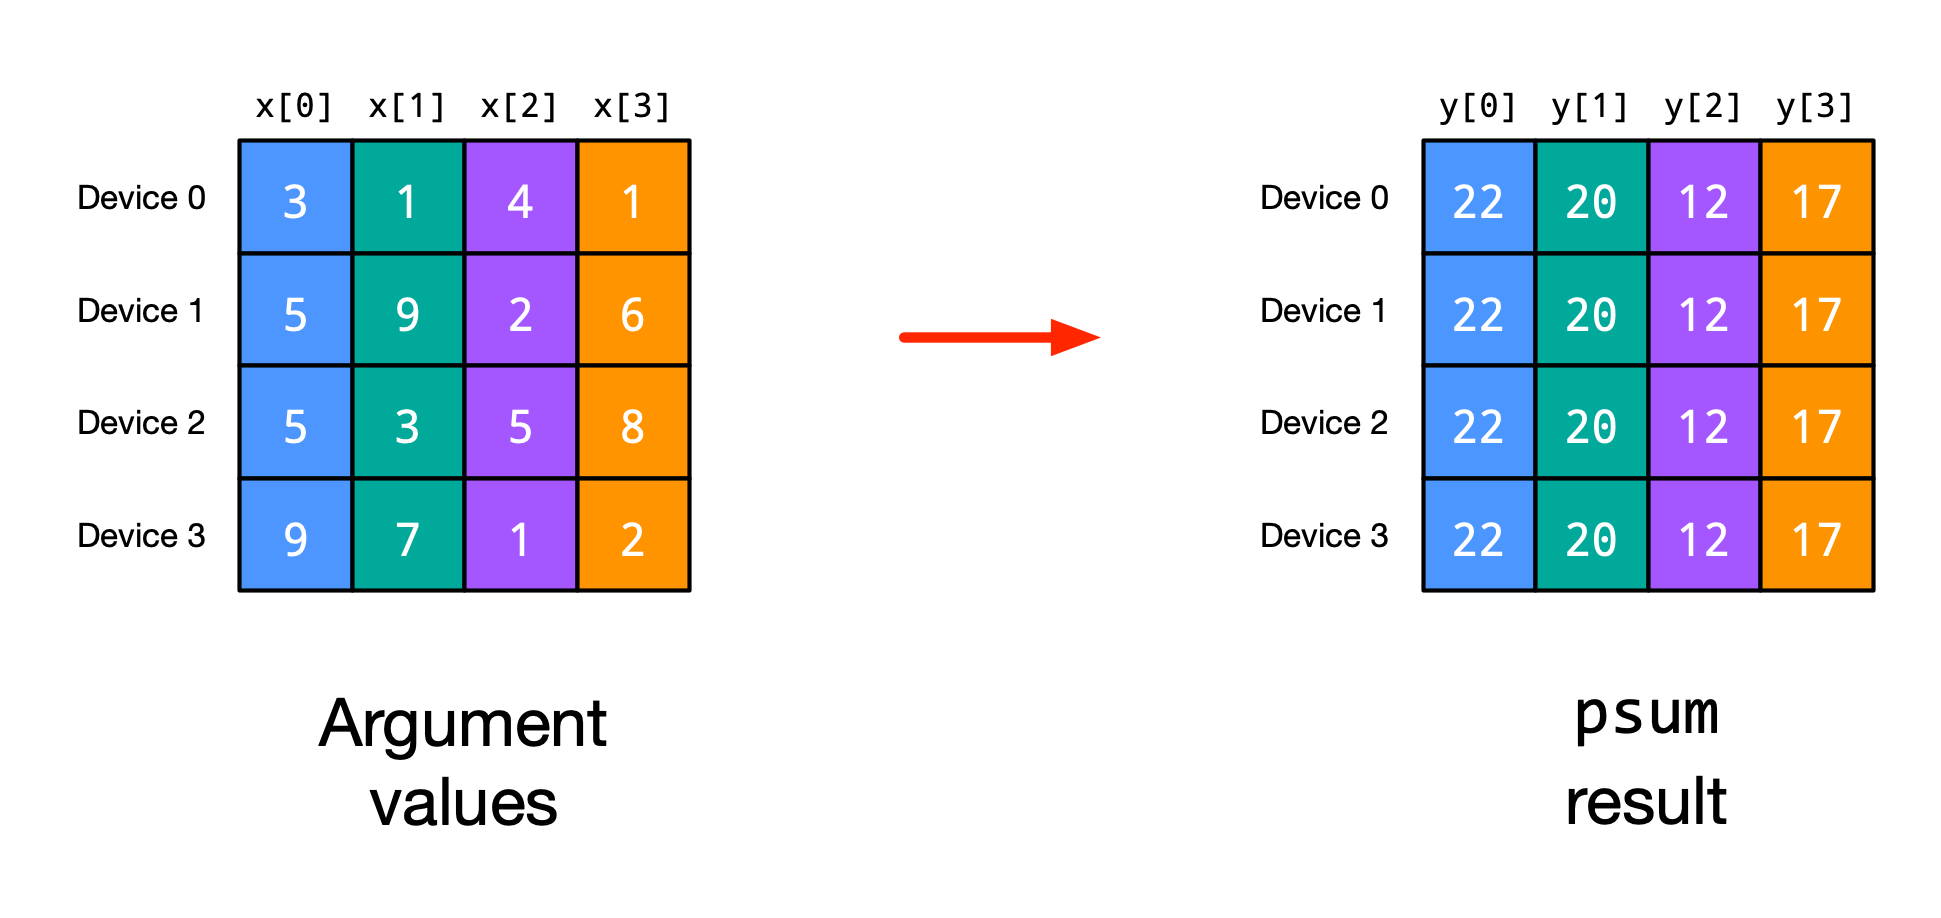

In [ ]:
import jax
import jax.numpy as jnp
from jax import lax

from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental.shard_map import shard_map

In [ ]:
mesh1d = Mesh(jax.devices()[:4], ('i',))

@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P(None))
def f1(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.psum(x_block, 'i')
  print('AFTER:\n', y_block)
  return y_block

In [ ]:
x = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 1, 2])
y = f1(x)
print('FINAL RESULT:\n', y)

The prints show that each function application starts with its own chunk of
the argument value `x_block`. After the `psum`, each function application has
the same value of `y_block`, computed by summing the applications' `x_block`
values together.

In the case where there's a single axis name in the computation, we could say
that the `collective_ref` reference implementation for `psum` is

```python
def psum_ref(_, x_blocks):
  tot = sum(x_blocks)
  return [tot] * len(x_blocks)
```

Notice also that because `f1` returns `y_block`, the result of a `psum` over
`'i'`, we can use `out_specs=P()` so the caller gets a single logical copy of
the result value, rather than a tiled result.

When there is more than one mesh axis, we can perform a `psum` over
each one separately, or over multiple axes at once:

In [ ]:
mesh2d = Mesh(np.array(jax.devices()[:4]).reshape(2, 2), ('i', 'j'))

@partial(shard_map, mesh=mesh2d, in_specs=P('i', 'j'), out_specs=P(None, 'j'))
def f2(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.psum(x_block, 'i')
  print('AFTER:\n', y_block)
  return y_block

y = f2(jnp.arange(16).reshape(4, 4))
print('FINAL RESULT:\n', y)

By applying a `psum` over mesh axis `'i'`, we get values of `y_block` which
are equal along axis '`i'`, but not axis `'j'`. (So we can use
`out_specs=P(None, 'j')` to get a single logical result along that axis.)

If we apply the `psum` over both axes, the `y_block` value is equal along both
axes:

In [ ]:
@partial(shard_map, mesh=mesh2d, in_specs=P('i', 'j'), out_specs=P(None, None))
def f3(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.psum(x_block, ('i', 'j'))
  print('AFTER:\n', y_block)
  return y_block

y = f3(jnp.arange(16).reshape(4, 4))
print('FINAL RESULT:\n', y)

In machine learning, we often use `psum` to compute total losses or, when we
have a `grad` inside the `shard_map`ped function body, total gradients.

In the sequel, we'll see how `psum` can be implemented in terms of other
primitives, which gives some intuition about its communication cost.

### `all_gather`

Another fundamental operation is gathering array shards along an axis, so that
each function application has a full copy of the data along that axis:

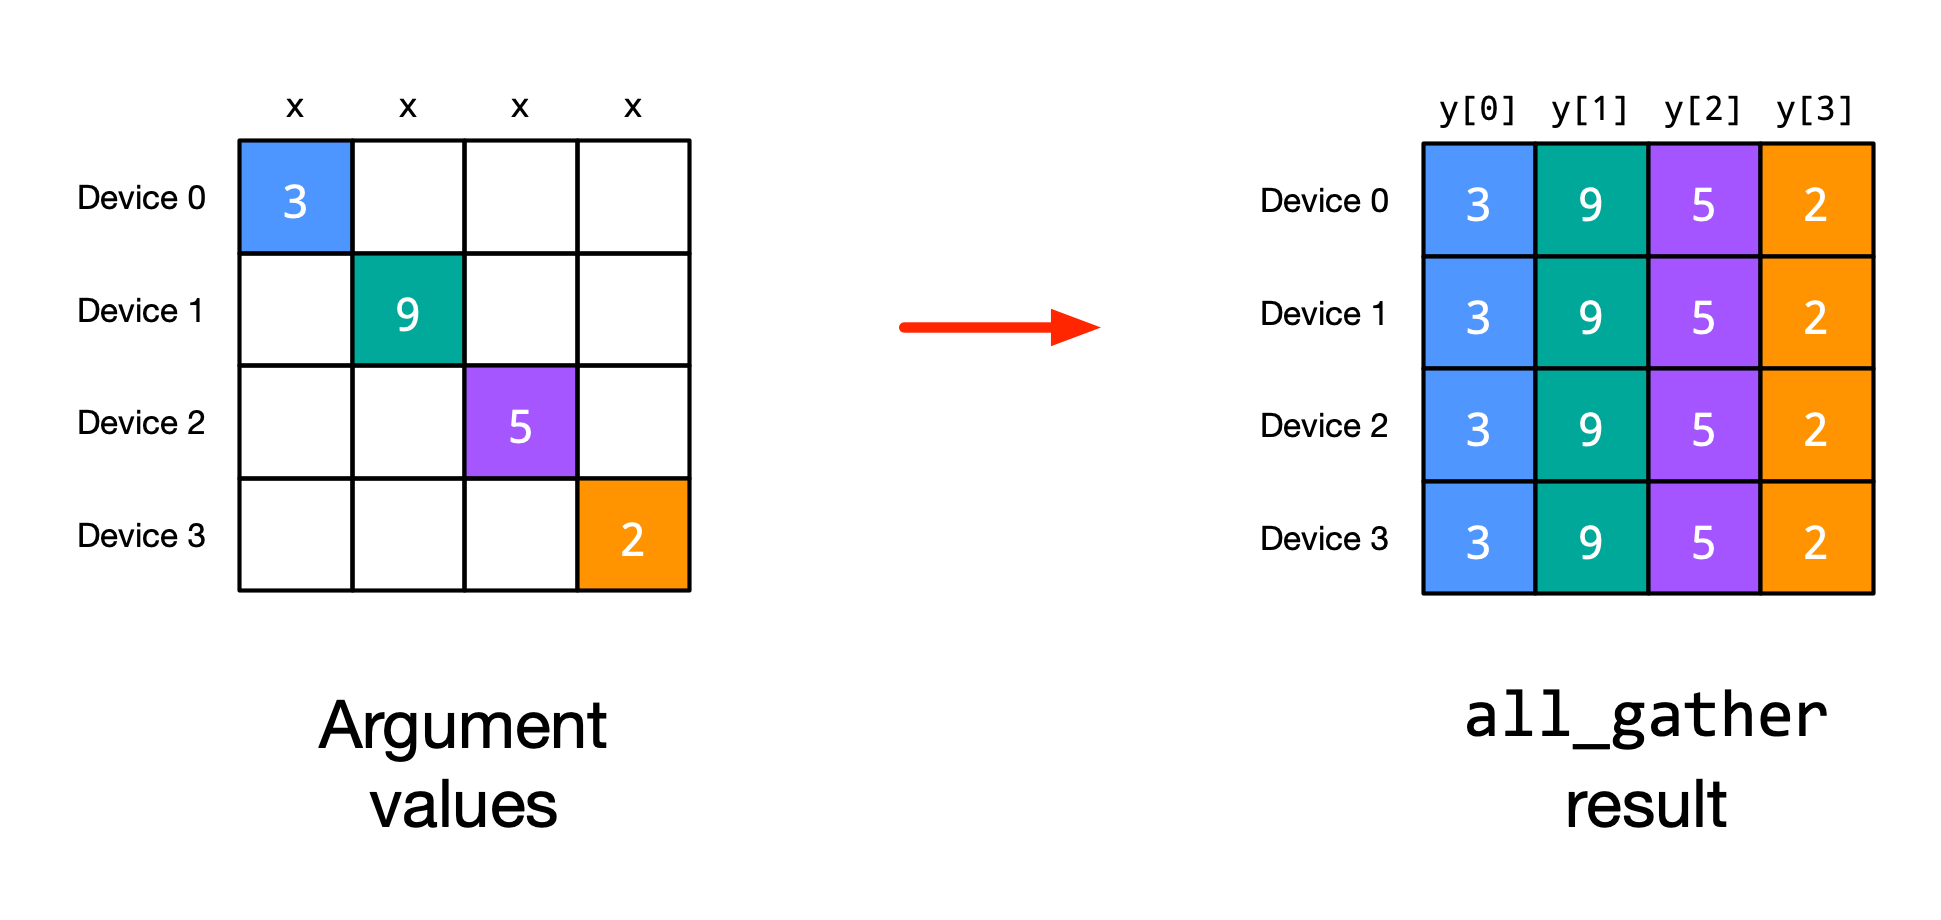

In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f4(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.all_gather(x_block, 'i', tiled=True)
  print('AFTER:\n', y_block)
  return y_block

x = jnp.array([3, 9, 5, 2])
y = f4(x)
print('FINAL RESULT:\n', y)

The prints show that each function application again starts with its own chunk
of the argument value `x_block`. After the `all_gather`, they have a common
value, computed by concatenating the values of `x_block`.

(Notice that we actually can't set `out_specs=P()` here. For technical
reasons related to automatic differentiation, we consider the output of
`all_gather` not to be guaranteed invariant across devices. If we wanted it to
be guaranteed invariant, we could use `jax.lax.all_gather_invariant`, or in
this case we could just avoid doing the `all_gather` in the function body and
instead just use `out_specs=P('i')` to perform the concatenation.)

When `tiled=False` (the default), results are stacked along a new axis instead
of concatenated:

In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f5(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.all_gather(x_block, 'i', tiled=False)
  print('AFTER:\n', y_block)
  return y_block

y = f5(x)
print('FINAL RESULT:\n', y)

We could write the `collective_ref` reference semantics function for
`all_gather` as

```python
def all_gather_ref(_, x_blocks, *, tiled=False):
  combine = jnp.concatenate if tiled else jnp.stack
  return [combine(x_blocks)] * len(x_blocks)
```

In deep learning, we might use `all_gather`s on parameters in fully sharded
data parallelism (FSDP).

### `psum_scatter`

The `jax.lax.psum_scatter` collective is a bit less intuitive. It's like
`psum` except each function instance gets only one shard of the result:

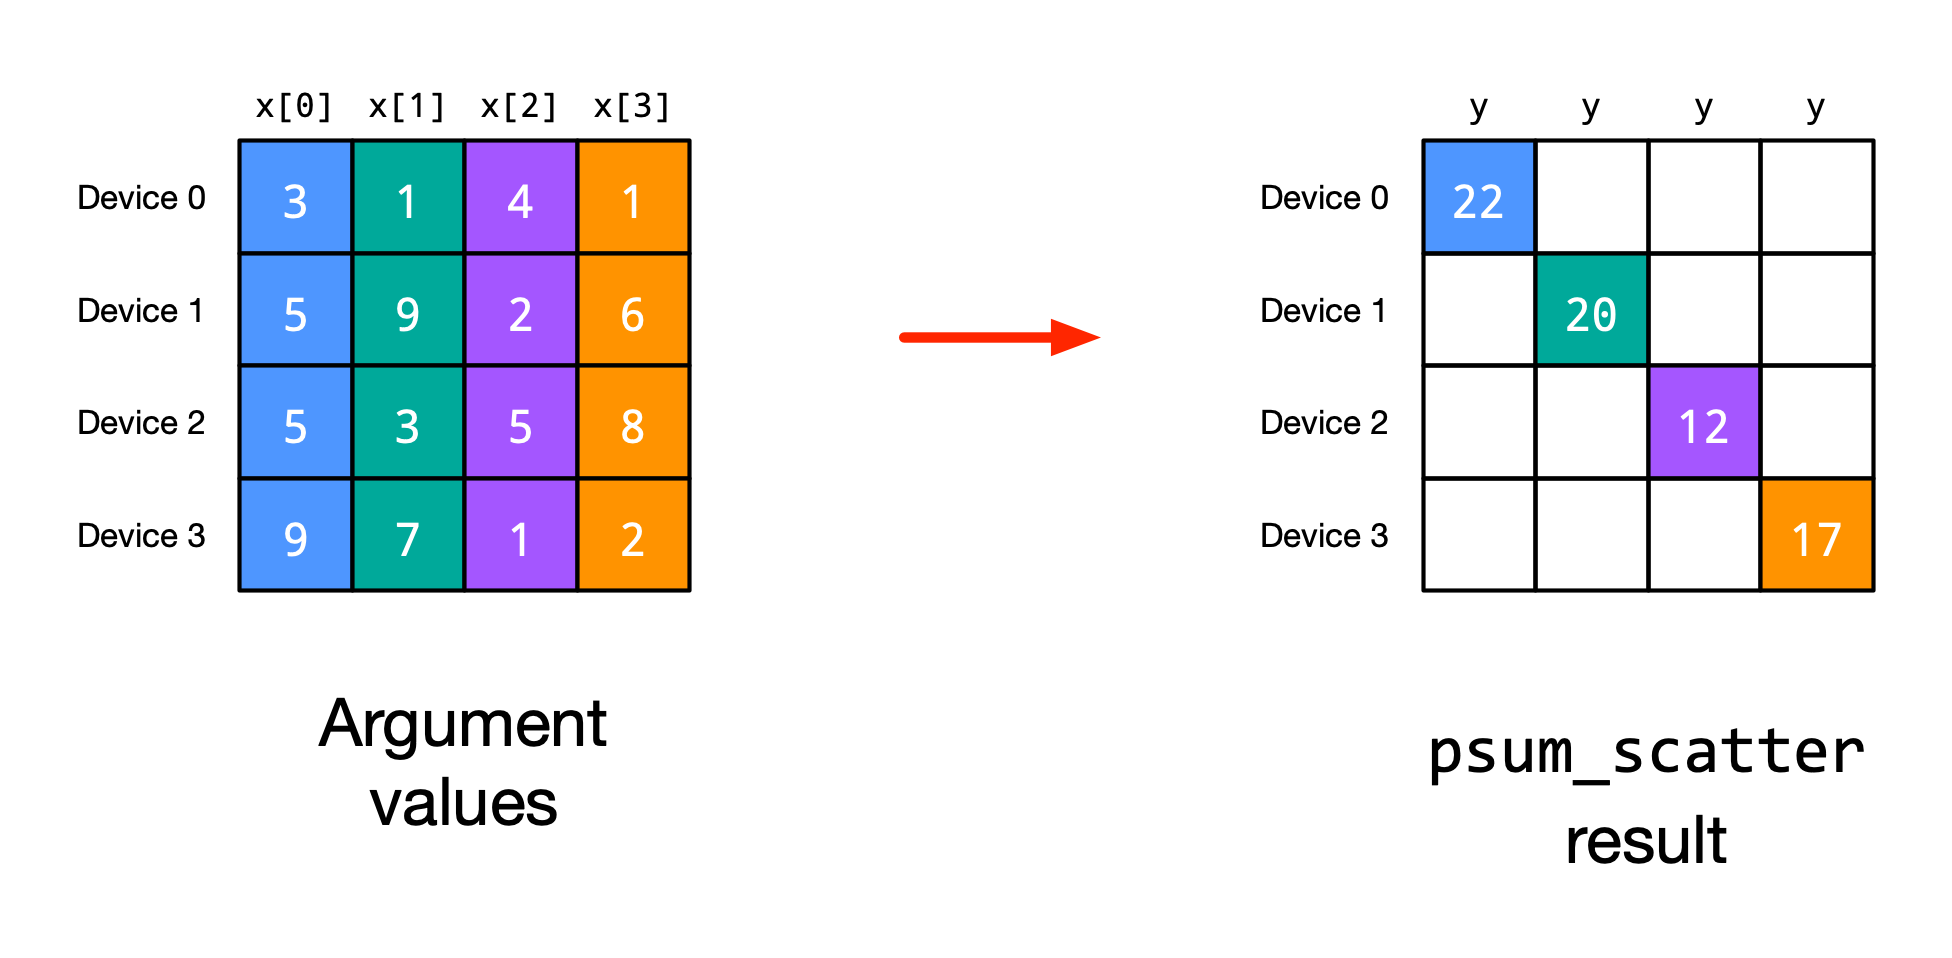

In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f6(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.psum_scatter(x_block, 'i', tiled=True)
  print('AFTER:\n', y_block)
  return y_block

x = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 1, 2])
y = f6(x)
print('FINAL RESULT:\n', y)

As shown by the prints, each resulting `y_block` has a smaller size than the
argument `x_block`, unlike with `psum`. Moreover, compared to `psum`, here
each `y_block` only represents a slice of the sum of the `x_block`s across
function instances. (Even though each function instance gets only one shard of
the sum, the final output `y` is the same as in the `psum` example because
here we use `out_specs=P('i')` to concatenate each function instance's
output.)

In terms of what values are computed, a `collective_ref` reference
implementation might look like:

```python
def psum_scatter_ref(i, x_blocks, *, tiled=False):
  axis_size = len(x_blocks)
  tot = sum(x_blocks)
  if tiled:
    tot = tot.reshape(axis_size, -1, *tot.shape[1:])  # split leading axis
  return [tot[i] for i in range(tot.shape[0])]
```

It's not captured in the semantics reference implementation, but
`psum_scatter` is useful because these results can be computed more
efficiently, with less communication, than a full `psum`. In fact, one way to
think of `psum_scatter` is as "the first half of a `psum`, before an
`all_gather`". That is, one way to implement `psum` is:

```python
def psum(x, axis_name):
  summed_chunk = jax.lax.psum_scatter(x, axis_name)
  return jax.lax.all_gather(summed_chunk, axis_name)
```

Indeed, this implementation is often used on both TPU and GPU!

The reason `psum_scatter` can require about half the communication as a full
`psum` is illustrated in the `ppermute` section.

Another intuition is that we can use `psum_scatter` to implement a distributed
matrix multiplication with inputs and outputs sharded over the same axis. In
machine learning, `psum_scatter` can be used in tensor-parallel matrix
multiplies or fully-sharded data parallel gradient accumulation, as shown in
the examples to follow.

### `ppermute`

The `jax.lax.ppermute` collective provides the most direct way for
function instances to send data to one another. Given a mesh axis and a
list of `(source_index, destination_index)` pairs representing indices along
that mesh axis, `ppermute` sends its argument value from each source function
instance to each destination:

In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f7(x_block):
  sz = jax.lax.psum(1, 'i')
  print('BEFORE:\n', x_block)
  y_block = jax.lax.ppermute(x_block, 'i', [(i, (i + 1) % sz) for i in range(sz)])
  print('AFTER:\n', y_block)
  return y_block

y = f7(jnp.arange(8))
print('FINAL RESULT:\n', y)

In this case, with just two function instances, each instance's value of
`y_block` is the other's value of `x_block`.

Source indices and destination indices can't be repeated. If an index does not
appear as a destination, then the value of the corresponding function
instance's result is an array of zeros.

A `collective_ref` reference implementation could look like

```python
def ppermute_ref(i, x_blocks, perm):
  results = [jnp.zeros_like(x_blocks[0])] * len(x_blocks)
  for src, dst in perm:
    results[dst] = x_blocks[src]
  return results
```

Other collectives can be implemented efficiently, in terms of total
communication, using `ppermute`s where each function passes data only to its
neighbors. For example, we could implement `psum_scatter` using a sequence of
`ppermute`s and local additions this way:

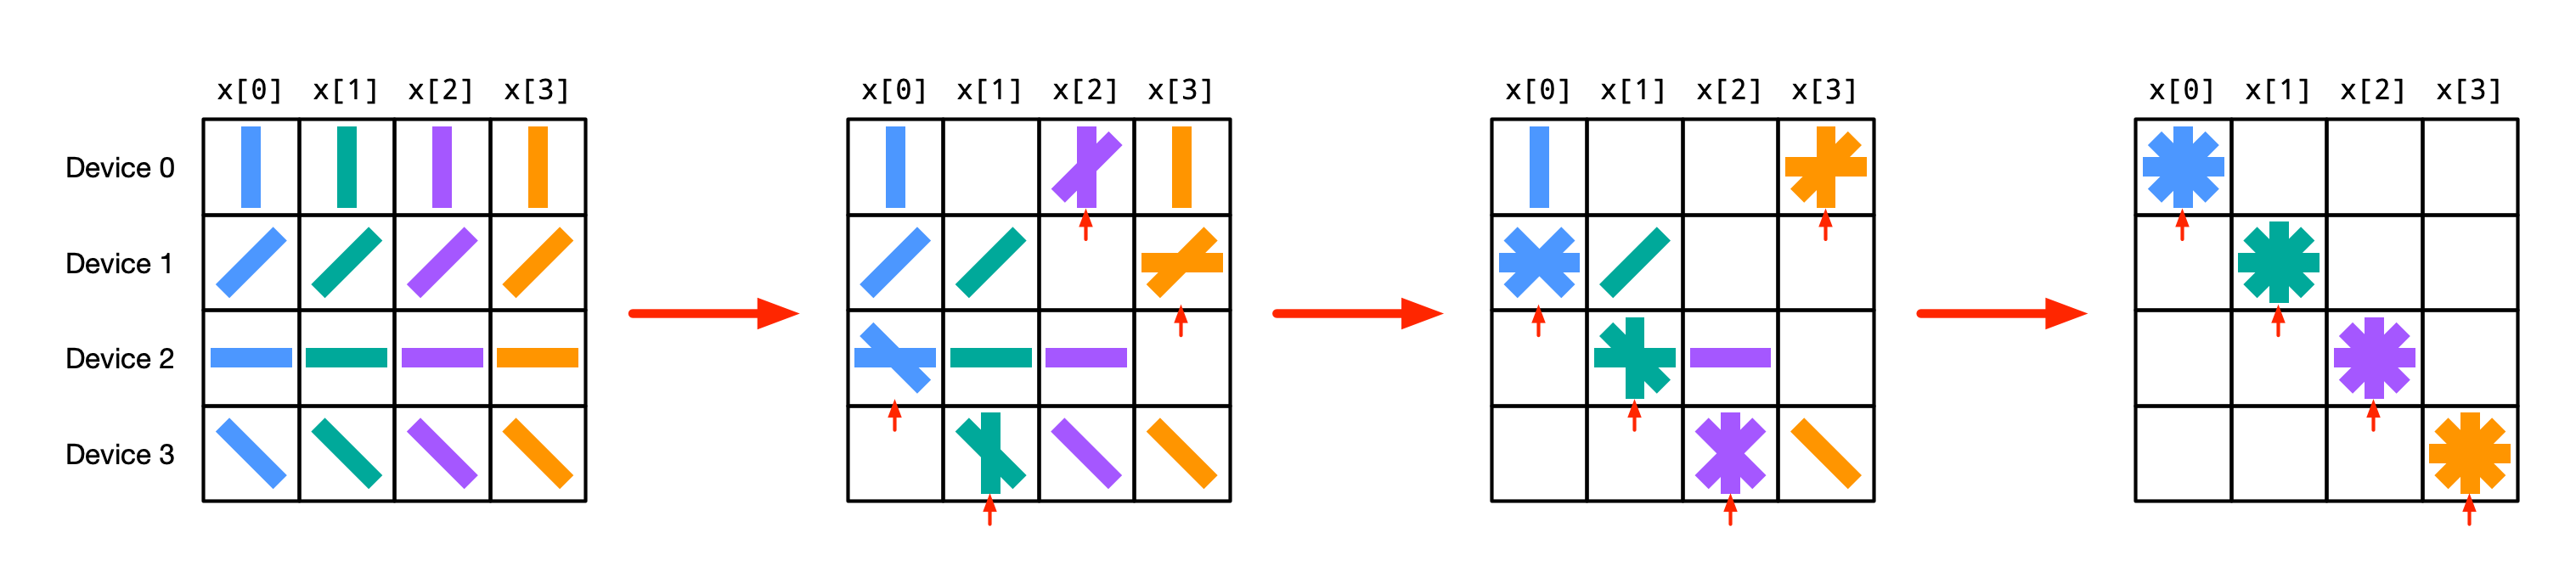

Or, with a numerical example:

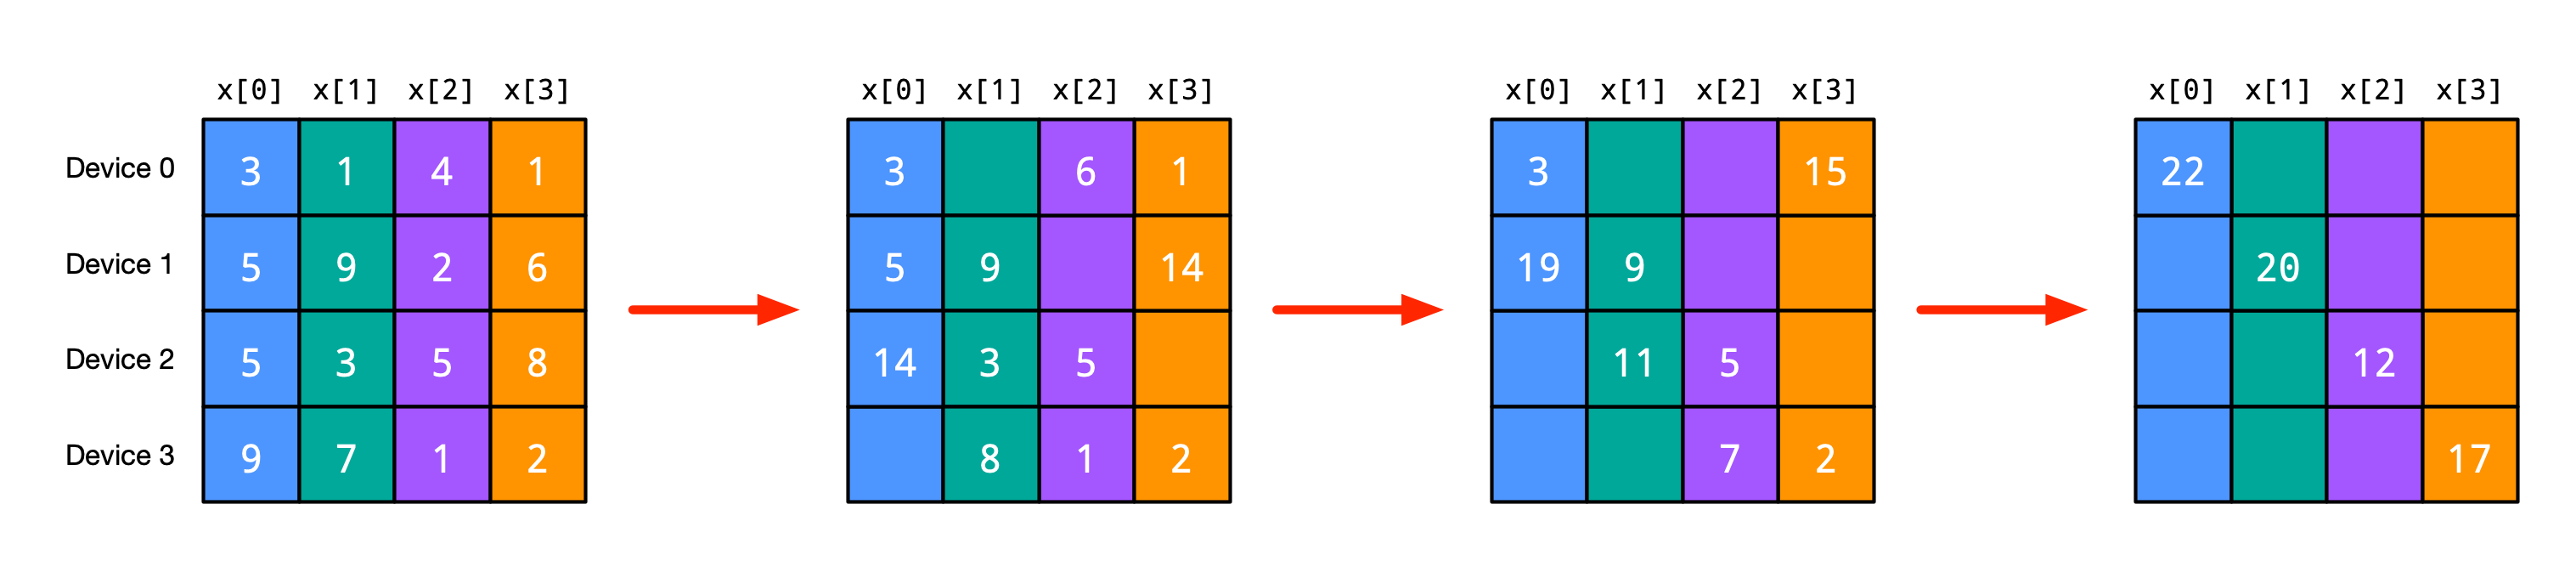


Intuitively, on each iteration each function instance sends 'up' the value it
received on the previous iteration, and reduces (adds) the value it receives
this iteration. In code, it might look like this:

In [ ]:
def psum_scatter(x, axis_name, *, tiled=False):
  size = jax.lax.psum(1, axis_name)
  idx = jax.lax.axis_index(axis_name)  # function instance index along axis_name
  if tiled:
    x = x.reshape(size, -1, *x.shape[1:])  # split leading axis
  shift = partial(jax.lax.ppermute, axis_name=axis_name,
                  perm=[(i, (i - 1) % size) for i in range(size)])
  for i in range(1, size):
    update = shift(x[(idx + i) % size])
    x = x.at[(idx + i + 1) % size].add(update)
  return x[idx]

In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f8(x_block):
  print('BEFORE:\n', x_block)
  y_block = psum_scatter(x_block, 'i', tiled=True)
  print('AFTER:\n', y_block)
  return y_block

x = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 1, 2])
y = f8(x)
print('FINAL RESULT:\n', y)

On TPU, there are higher-dimensional variants of this algorithm to exploit
multiple bidirectional physical mesh axes.

Notice that `psum_scatter` is the transpose of `all_gather`. Indeed, a way to
implement `all_gather` in terms of `ppermute` looks like the reverse of the
above process:

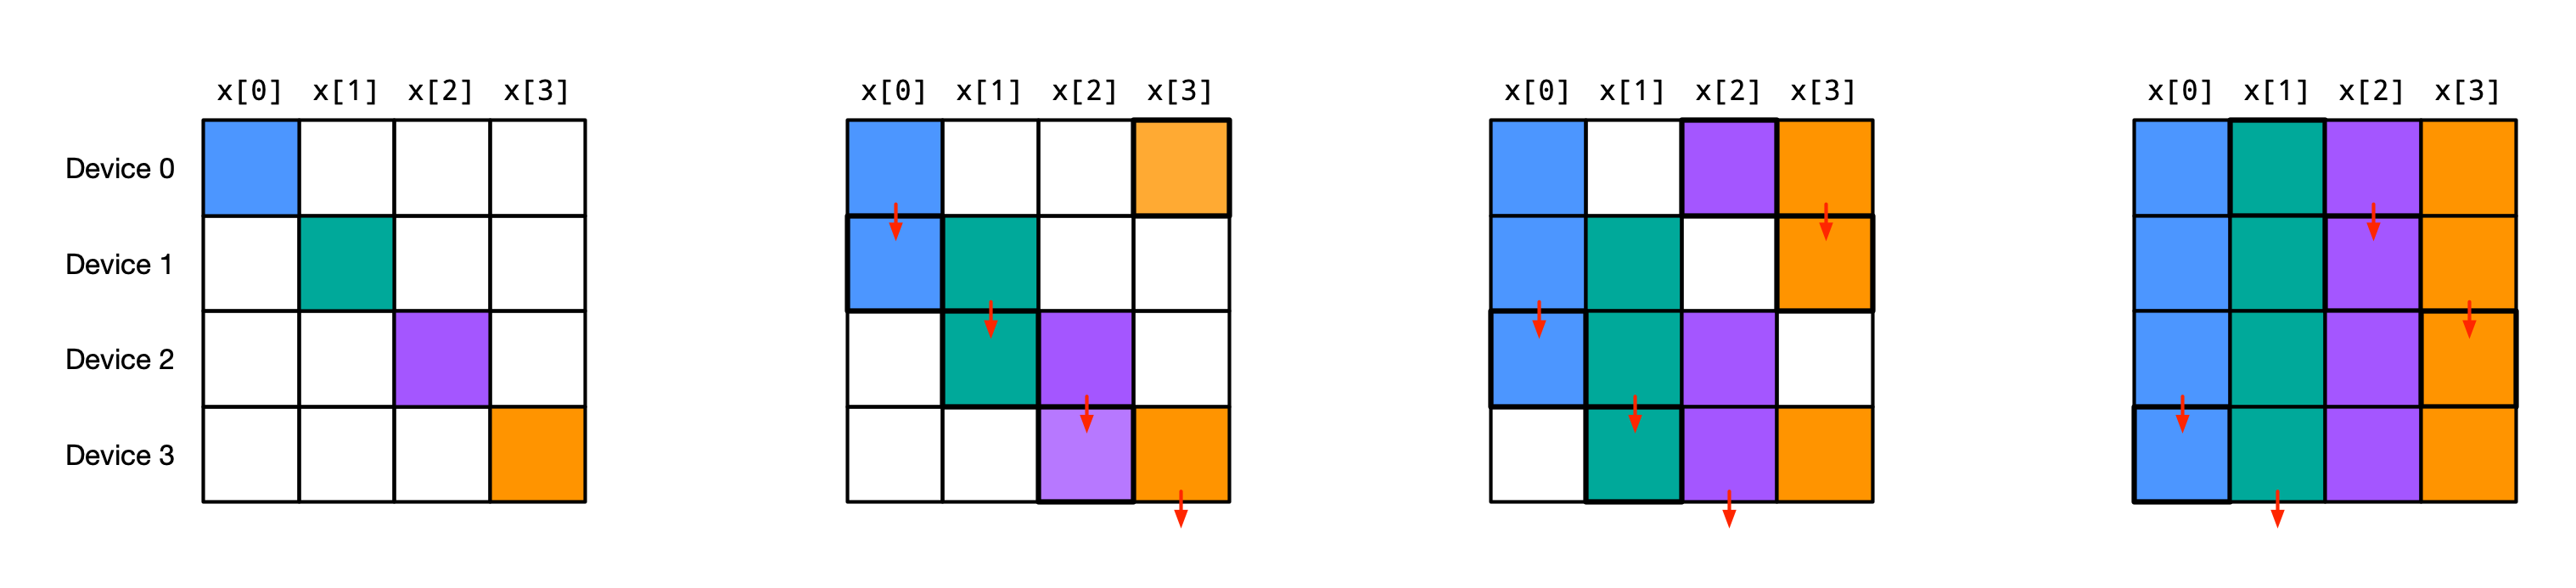

In deep learning, we might use `ppermute` when implementing SPMD pipeline
parallelism, where we divide our network along its depth into stages and
evaluate the applications of stages in parallel. Or we might use `ppermute` in
parallelizing the evaluation of convolutional layers, where we shard over
spatial axes and thus devices must communicate "halos" to each other. Or it
may be used under-the-hood in tensor-parallel matrix multiplies.

### `all_to_all`

A final collective is `all_to_all`, which is essentially a block matrix
transpose operating along one positional axis and one cross-device axis:

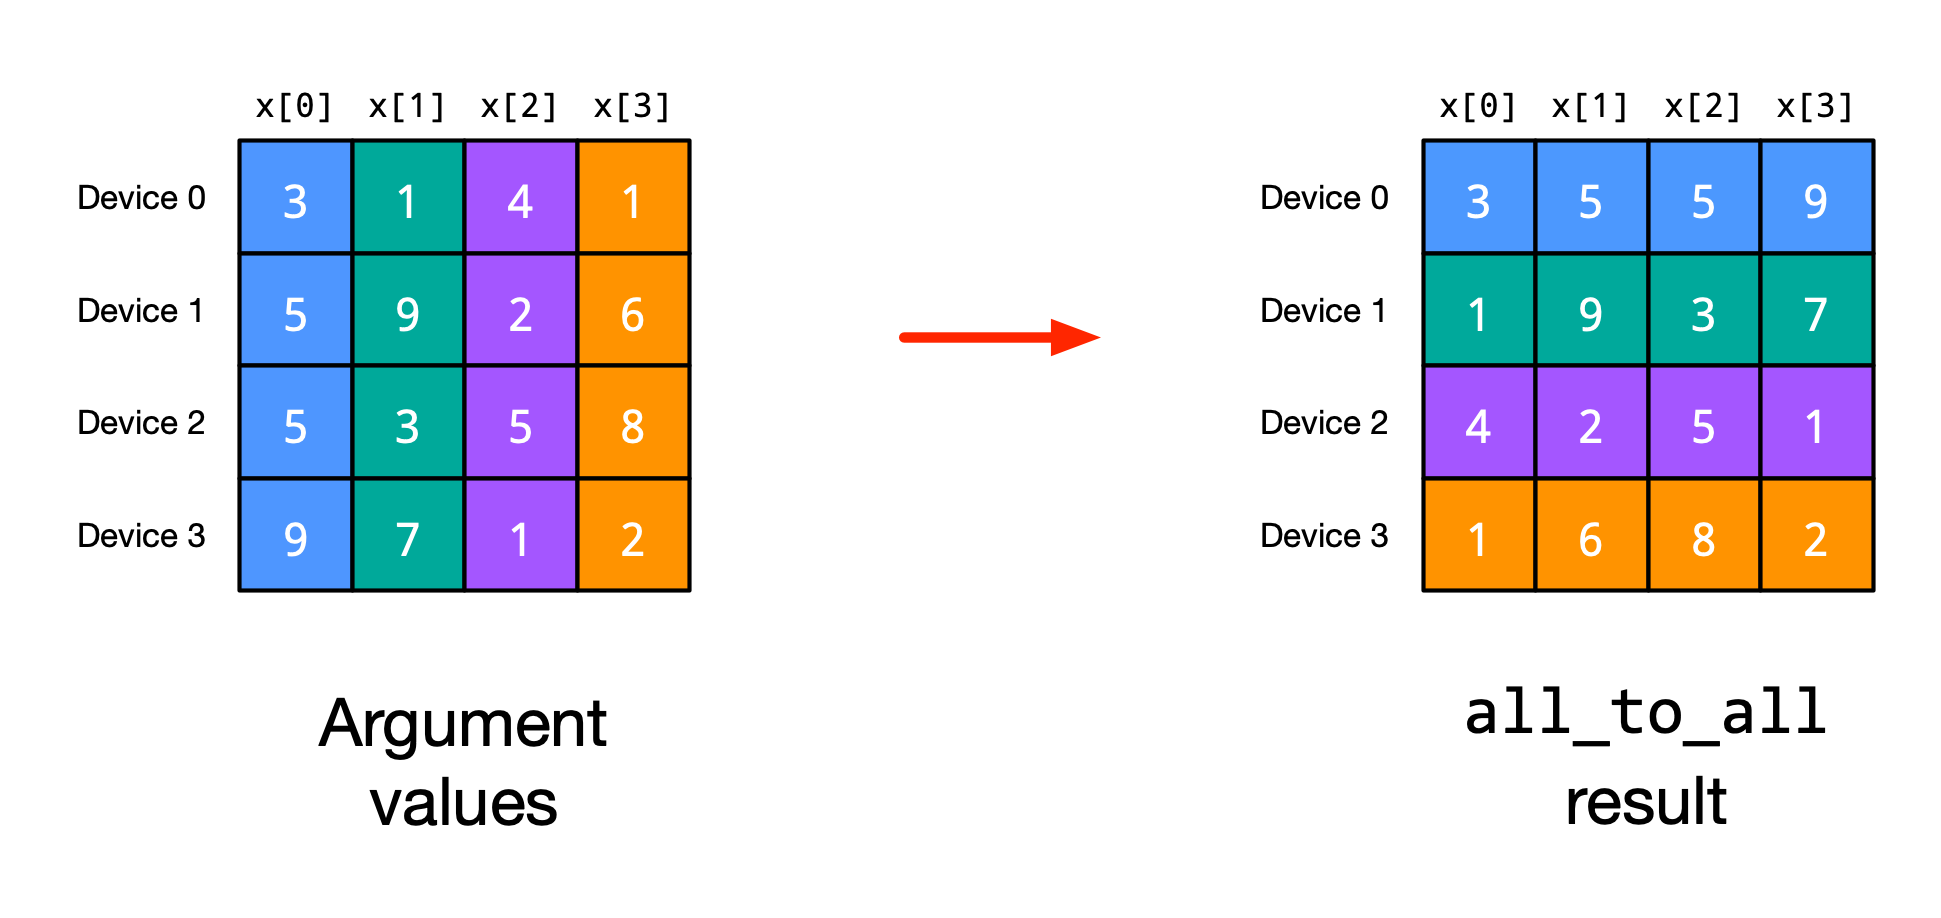

In [ ]:
@partial(shard_map, mesh=mesh1d, in_specs=P('i'), out_specs=P('i'))
def f9(x_block):
  print('BEFORE:\n', x_block)
  y_block = jax.lax.all_to_all(x_block, 'i', split_axis=0, concat_axis=0,
                               tiled=True)
  print('AFTER:\n', y_block)
  return y_block

x = jnp.array([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5, 8, 9, 7, 1, 2])
y = f9(x)
print('FINAL RESULT:\n', y)

The `split_axis` argument indicates which positional axis should be sharded
and partitioned across the mesh axis. The `concat_axis` argument indicates the
axis along which the communicated results should be concatenated or stacked.

When `tiled=False` (the default), the `split_axis` axis size must equal the
size of the mesh axis named `axis_name`, and a new axis of that size is
created at position `concat_axis` for the stacked results. When `tiled=True`,
the `split_axis` axis size need only be evenly divisible by the size of the
mesh axis, and results are concatenated along the existing axis `concat_axis`.

The `collective_ref` reference semantics when `split_axis=0` and
`concat_axis=0` might look like:

```python
def all_to_all_ref(_, x_blocks, *, tiled=False):
  axis_size = len(x_blocks)
  if tiled:
    splits = [jnp.array_split(x, axis_size) for x in x_blocks]
    return [jnp.concatenate(s) for s in zip(*splits)]
  else:
    splits = [list(x) for x in x_blocks]
    return [jnp.stack(s) for s in zip(*splits)]
```

In deep learning, we might use `all_to_all` in mixture-of-expert routing,
where we first sort our local batch of examples according to which expert they
should go to, then apply an `all_to_all` to redistribute examples to experts.

## Toy examples

How might we use `shard_map` and collective communication in practice? These
examples, while simple, give some idea.

### Matrix multiplies

Parallelizing matrix multiplication is central in scaling up deep learning
models, both for training and for inference. When `jax.jit` automatically
parallelizes matrix multiplication, it can use one of several different
strategies, depending on matrix sizes, hardware details, and other factors. How
might we write some of those parallelized routines more explicitly using
`shard_map`? And how can we optimize them to get better compute/communication
overlap and thus improve FLOP utilization?

In [ ]:
import jax
import jax.numpy as jnp

from jax.sharding import Mesh, NamedSharding, PartitionSpec as P
from jax.experimental.shard_map import shard_map

In [ ]:
mesh = Mesh(jax.devices()[:4], ('i',))

def device_put(x, pspec):
  return jax.device_put(x, NamedSharding(mesh, pspec))

#### Example 1: `all-gather` on one side

Consider performing a matrix multiplication where we shard the left-hand side
argument (can think: parameters) on its leading (non-contracting) dimension:

In [ ]:
lhs_spec = P('i', None)
lhs = device_put(jax.random.normal(jax.random.key(0), (8, 8)), lhs_spec)

And we shard the right-hand side argument (can think: activations) on its
contracting dimension, with a similar sharding for the output:

In [ ]:
rhs_spec = P('i', None)
rhs = device_put(jax.random.normal(jax.random.key(1), (8, 4)), rhs_spec)

To perform this matrix multiplication, we can first all-gather the right-hand
side and then perform local matrix multiplies against the sharded left-hand
side:

In [ ]:
@jax.jit
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_allgather(lhs_block, rhs_block):
  rhs = jax.lax.all_gather(rhs_block, 'i', tiled=True)
  return lhs_block @ rhs

In [ ]:
out = matmul_allgather(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))

That's great, but we're not getting any compute/communication overlap
here: before we can start the matmul, we need the `all_gather` to complete.
Here's a profile using the same code, but on larger example shapes (`(8192,
8192)` for `lhs` and `(8192, 1024)` for `rhs`):

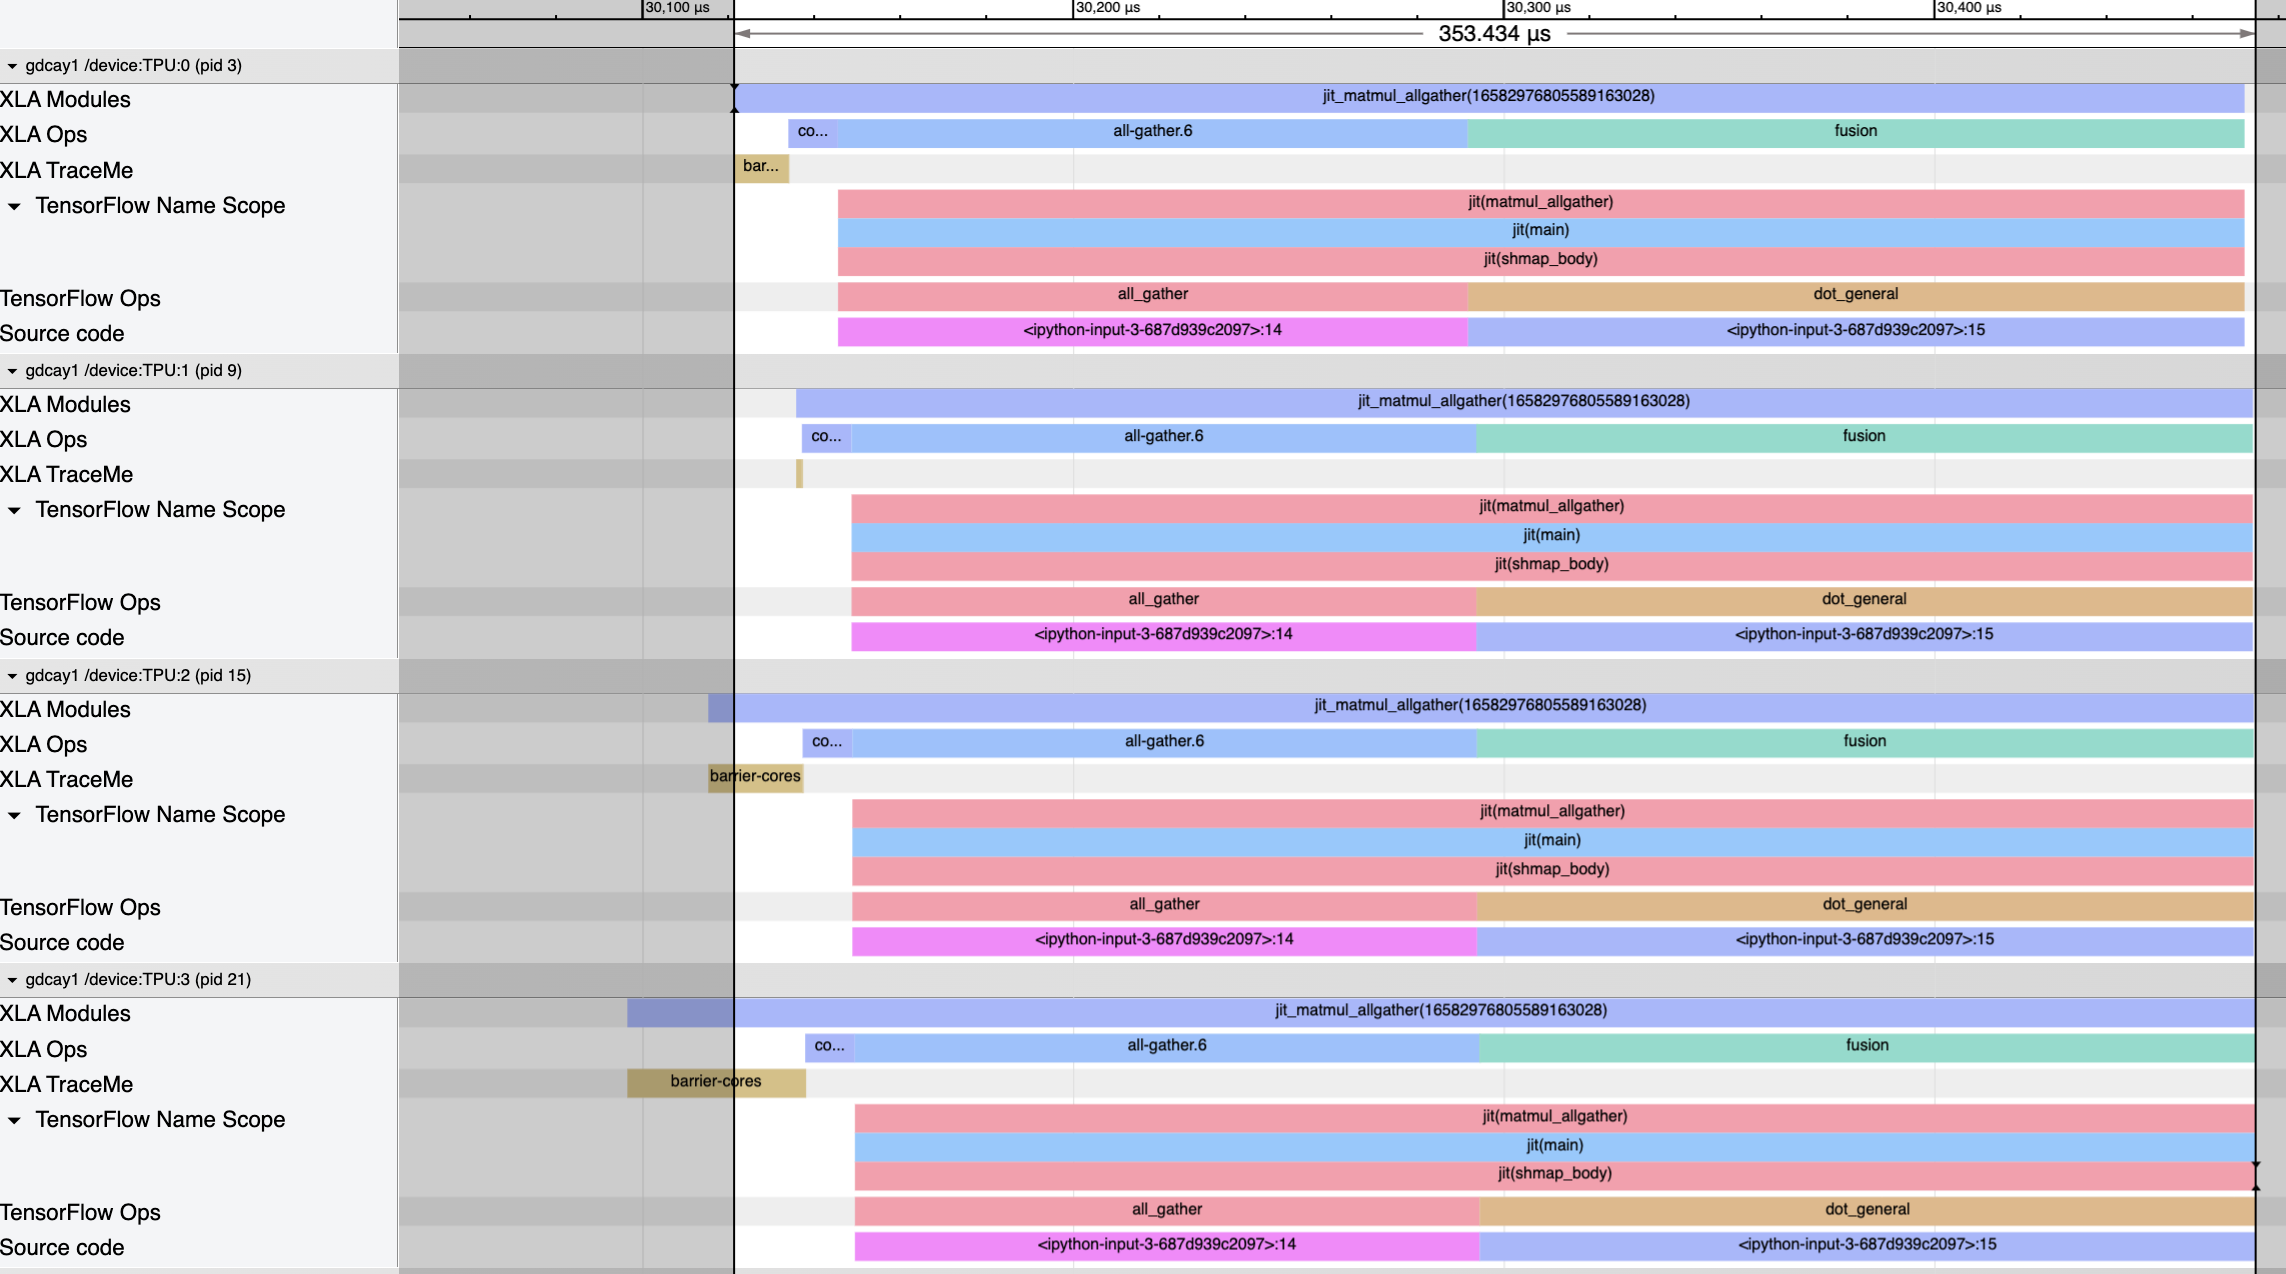

We can get compute/communication overlap if instead of calling `all_gather` we
basically inline our above implementation of `all_gather` in terms of
`ppermute`, then interleave steps of the gather permutation with local matrix
multiplies:

In [ ]:
@jax.jit
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_allgather_overlapped(lhs_block, rhs_block):
  size = jax.lax.psum(1, 'i')
  idx = jax.lax.axis_index('i')
  shift = partial(jax.lax.ppermute, axis_name='i',
                  perm=[(i, (i + 1) % size) for i in range(size)])

  B = lhs_block.shape[1] // size
  lhs_blocks = lambda i: lax.dynamic_slice_in_dim(lhs_block, i * B, B, 1)

  out_block = lhs_blocks(idx) @ rhs_block
  for i in range(1, size):
    rhs_block = shift(rhs_block)
    out_block += lhs_blocks((idx - i) % size) @ rhs_block
  return out_block

In [ ]:
out = matmul_allgather_overlapped(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))

This implementation allows overlap between communication and computation, and
also avoids gathering a large intermediate onto each device. But on TPU it uses
only half the interconnect bandwidth by permuting in only one direction along
the ring. To permute bidirectionally, we just split the blocks in half and send
each half in each direction:

In [ ]:
@jax.jit
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_allgather_overlapped_bidi(lhs_block, rhs_block):
  size = jax.lax.psum(1, 'i')
  idx = jax.lax.axis_index('i')
  shift_up = partial(jax.lax.ppermute, axis_name='i',
                     perm=[(i, (i + 1) % size) for i in range(size)])
  shift_dn = partial(jax.lax.ppermute, axis_name='i',
                     perm=[(i, (i - 1) % size) for i in range(size)])

  B = lhs_block.shape[1] // size // 2  # half-size blocks
  lhs_blocks = lambda i, hi: lax.dynamic_slice_in_dim(lhs_block, (2*i+hi) * B, B, 1)

  rhs_block_lo, rhs_block_hi = jnp.split(rhs_block, 2, axis=0)
  out_block  = lhs_blocks(idx, 0) @ rhs_block_lo
  out_block += lhs_blocks(idx, 1) @ rhs_block_hi
  for i in range(1, size):
    rhs_block_lo = shift_up(rhs_block_lo)
    rhs_block_hi = shift_dn(rhs_block_hi)
    out_block += lhs_blocks((idx - i) % size, 0) @ rhs_block_lo
    out_block += lhs_blocks((idx + i) % size, 1) @ rhs_block_hi
  return out_block

In [ ]:
out = matmul_allgather_overlapped_bidi(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))

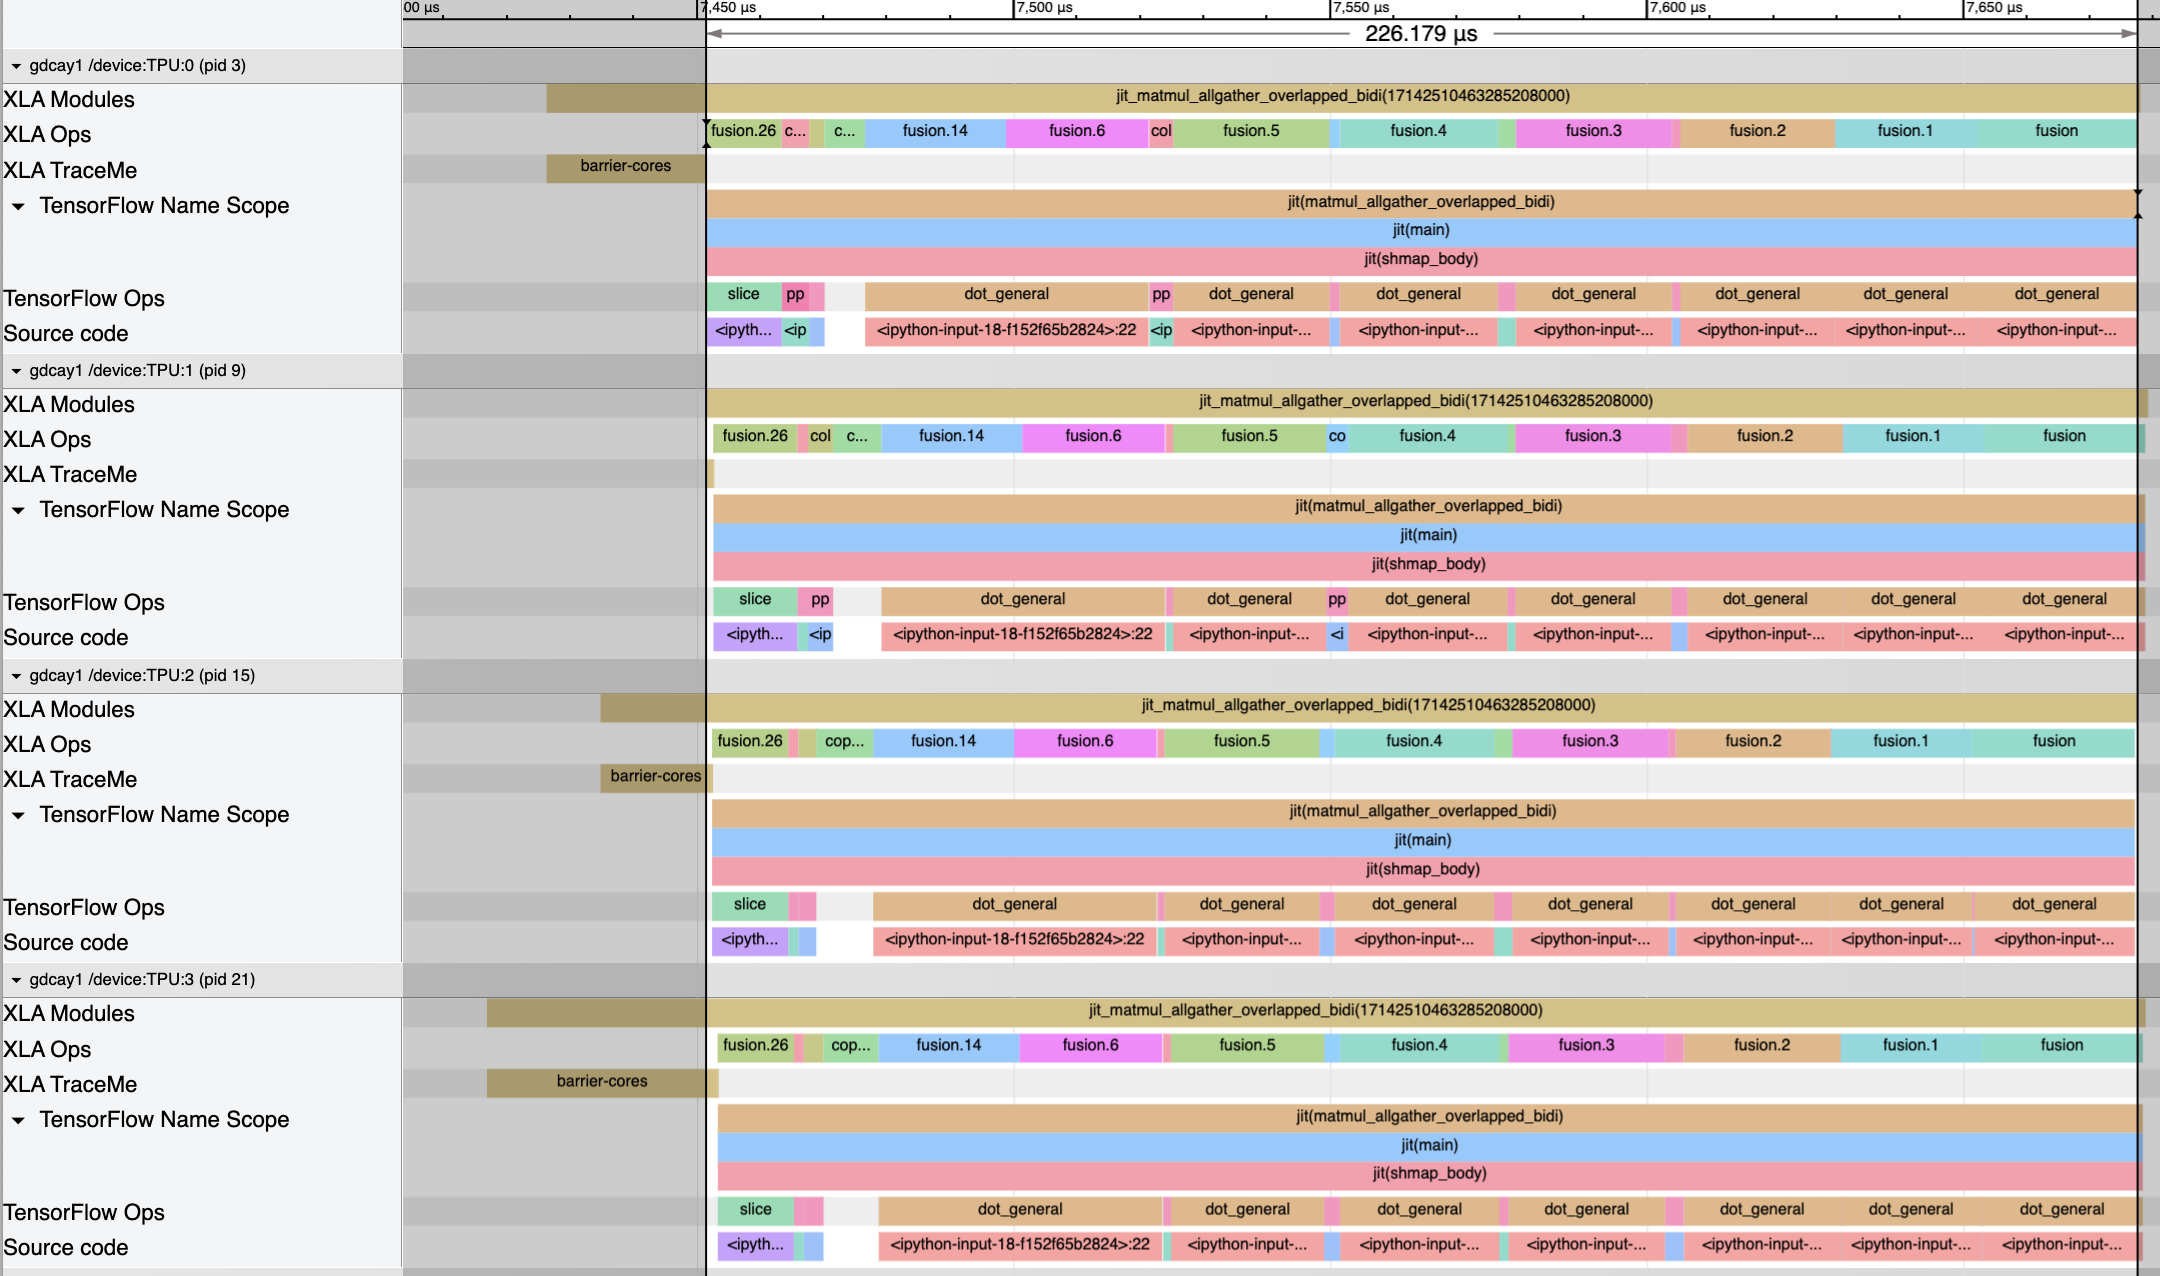

In practice, to reduce compile times we would probably roll this into a
`jax.lax.fori_loop`. We might also have additional axes of parallelism
involved.

#### Example 2: `psum_scatter` the result

Another sharding we might start with has both `lhs` and `rhs` sharded along
their contracting dimensions, with the output sharded like `rhs` again:

In [ ]:
lhs_spec = P(None, 'i')
lhs = device_put(lhs, lhs_spec)

rhs_spec = P('i', None)
rhs = device_put(rhs, rhs_spec)

Here we can use a `reduce_scatter` to perform the contraction sum over shards:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_psumscatter(lhs_block, rhs_block):
  out_summand = lhs_block @ rhs_block
  return jax.lax.psum_scatter(out_summand, 'i', tiled=True)

out = matmul_psumscatter(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))

But the scattering communication must wait for the entire local matrix multiply
to finish before it can start. To get communication/computation overlap, we can
inline an implementation of `psum_scatter` in terms of `ppermute`, then
interleave the communication steps with local matrix multiplies:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_psumscatter_overlapped(lhs_block, rhs_block):
  size = jax.lax.psum(1, 'i')
  idx = jax.lax.axis_index('i')
  shift = partial(jax.lax.ppermute, axis_name='i',
                  perm=[(i, (i - 1) % size) for i in range(size)])
  lhs_block = lhs_block.reshape(size, -1, lhs_block.shape[1])  # split 1st axis

  out_summand = lhs_block[(idx + 1) % size] @ rhs_block
  for i in range(1, size):
    out_summand = shift(out_summand)
    out_summand += lhs_block[(idx + i + 1) % size] @ rhs_block
  return out_summand

In [ ]:
out = matmul_psumscatter_overlapped(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))

As in the previous example, to fully utilize interconnects on TPU, we'd run a
bidirectional version:

In [ ]:
@partial(shard_map, mesh=mesh, in_specs=(lhs_spec, rhs_spec),
         out_specs=rhs_spec)
def matmul_psumscatter_overlapped_bidi(lhs_block, rhs_block):
  size = jax.lax.psum(1, 'i')
  idx = jax.lax.axis_index('i')
  shift_up = partial(jax.lax.ppermute, axis_name='i',
                     perm=[(i, (i + 1) % size) for i in range(size)])
  shift_dn = partial(jax.lax.ppermute, axis_name='i',
                     perm=[(i, (i - 1) % size) for i in range(size)])

  B = lhs_block.shape[0] // size // 2  # half-size blocks
  lhs_blocks = lambda i, hi: lax.dynamic_slice_in_dim(lhs_block, (2*i+hi) * B, B, 0)

  out_summand_lo = lhs_blocks((idx - 1) % size, 0) @ rhs_block
  out_summand_hi = lhs_blocks((idx + 1) % size, 1) @ rhs_block
  for i in range(1, size):
    out_summand_lo = shift_up(out_summand_lo)
    out_summand_hi = shift_dn(out_summand_hi)
    out_summand_lo += lhs_blocks((idx - i - 1) % size, 0) @ rhs_block
    out_summand_hi += lhs_blocks((idx + i + 1) % size, 1) @ rhs_block
  return jnp.concatenate([out_summand_lo, out_summand_hi])

In [ ]:
out = matmul_psumscatter_overlapped_bidi(lhs, rhs)
print(jnp.allclose(out, lhs @ rhs, atol=1e-3, rtol=1e-3))

### Neural networks

We can use `shard_map` to parallelize computation in neural networks, either by
itself or in combination with the automatic partitioning in `jax.jit`. This
section has a few examples based on this toy neural network and random data:

In [ ]:
import jax
import jax.numpy as jnp

def predict(params, inputs):
  for W, b in params:
    outputs = jnp.dot(inputs, W) + b
    inputs = jax.nn.relu(outputs)
  return outputs

def loss(params, batch):
  inputs, targets = batch
  predictions = predict(params, inputs)
  return jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))

In [ ]:
def init_layer(key, n_in, n_out):
  k1, k2 = jax.random.split(key)
  W = jax.random.normal(k1, (n_in, n_out)) / jnp.sqrt(n_in)
  b = jax.random.normal(k2, (n_out,))
  return W, b

def init(key, layer_sizes, batch_size):
  key, *keys = jax.random.split(key, len(layer_sizes))
  params = list(map(init_layer, keys, layer_sizes[:-1], layer_sizes[1:]))

  key, *keys = jax.random.split(key, 3)
  inputs = jax.random.normal(keys[0], (batch_size, layer_sizes[0]))
  targets = jax.random.normal(keys[1], (batch_size, layer_sizes[-1]))

  return params, (inputs, targets)

In [ ]:
layer_sizes = [784, 128, 128, 128, 128, 128, 8]
batch_size = 32

params, batch = init(jax.random.key(0), layer_sizes, batch_size)

Compare these examples with the purely [automatic partitioning examples in the
"Distributed arrays and automatic partitioning"
doc](https://docs.jax.dev/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html).
While in those automatic partitioning examples we don't need to edit the model
functions to use different parallelization strategies, with `shard_map` we
often do.

#### 8-way batch data parallelism

The simplest multi-device parallelism strategy is to shard the batch of inputs
and targets over multiple devices, replicate the parameters over those devices,
and apply the model in parallel to those shards of data. To evaluate the total
loss, the devices need only communicate with a scalar-sized all-reduce-sum at
the end. (To evaluate the gradient of the loss, the devices must perform
all-reduce-sums of parameter gradients in the backward pass.)

In [ ]:
from functools import partial

from jax.sharding import NamedSharding, Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map

mesh = jax.make_mesh((8,), ('batch',))

# replicate initial params on all devices, shard data batch over devices
batch = jax.device_put(batch, NamedSharding(mesh, P('batch')))
params = jax.device_put(params, NamedSharding(mesh, P()))

# adapt the loss function to sum the losses across devices
def loss_dp(params, batch):
  @partial(shard_map, mesh=mesh, in_specs=P('batch', None), out_specs=P())
  def loss_spmd(local_batch):
    inputs, targets = local_batch
    predictions = predict(params, inputs)  # use reference 'predict`
    local_loss = jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))
    return jax.lax.pmean(local_loss, 'batch')
  return loss_spmd(batch)

We can check that the loss and its gradients match the reference (base) model:

In [ ]:
print(jax.jit(loss)(params, batch))
print(jax.jit(loss_dp)(params, batch))

In [ ]:
def allclose(a, b):
  return tree_all(tree_map(partial(jnp.allclose, atol=1e-2, rtol=1e-2), a, b))

print(allclose(jax.jit(jax.grad(loss))(params, batch),
               jax.jit(jax.grad(loss_dp))(params, batch)))

We can print the compiler IR to inspect the gradient computation and verify
that the collective all-reduce-sum operations happen where we'd expect: at the
end of the forward pass to compute the loss value, and in the backward pass to
compute the total parameter gradients.

#### 8-way fully sharded data parallelism (FSDP)

Another strategy is to additionally shard the parameters over the devices,
all-gathering each one when the full value is needed for the `jnp.dot` or bias
addition. Since we only have one full parameter in local device memory at a
time, rather than keeping all parameters in all device memories as in the
preceding DP example, we free up significant memory that we can use for larger
models or larger batch sizes. And because XLA will overlap computation and
inter-device communication, the wall-clock time doesn't suffer.

So now we need collectives in two places: the model prediction function
`predict` needs to all-gather the parameters before they're used, and as in the
DP case the loss function needs to sum the local losses to compute the total
loss.

There's one other ingredient we need: we don't want to store the fully gathered
parameters from the forward pass for use on the backward pass. Instead, we want
to gather them again on the backward pass. We can express that by using
`jax.remat` with a [custom
policy](https://docs.jax.dev/en/latest/notebooks/autodiff_remat.html#custom-policies-for-what-s-saveable)
(or a `custom_vjp`), though XLA typically does that rematerialization
automatically.

This general [FSDP
approach](https://engineering.fb.com/2021/07/15/open-source/fsdp/) is similar
to [weight update sharding (WUS)](https://arxiv.org/abs/2004.13336) and
[ZeRO-3](https://arxiv.org/abs/1910.02054).

In [ ]:
# shard data batch *and params* over devices
mesh = Mesh(devices, ('batch',))
batch = jax.device_put(batch, NamedSharding(mesh, P('batch')))
params = jax.device_put(params, NamedSharding(mesh, P('batch')))

# adapt the prediction function to gather weights just before their use,
# and to re-gather them on the backward pass (rather than saving them)
@partial(jax.remat, policy=lambda op, *_, **__: str(op) != 'all_gather')
def predict_fsdp(params_frag, inputs):
  for W_frag, b_frag in params_frag:
    W = jax.lax.all_gather(W_frag, 'batch', tiled=True)
    b = jax.lax.all_gather(b_frag, 'batch', tiled=True)
    outputs = jnp.dot(inputs, W) + b
    inputs = jax.nn.relu(outputs)
  return outputs

def loss_fsdp(params, batch):
  @partial(shard_map, mesh=mesh, in_specs=P('batch'), out_specs=P())
  def loss_spmd(local_params, local_batch):
    inputs, targets = local_batch
    predictions = predict_fsdp(local_params, inputs)
    local_loss = jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))
    return jax.lax.pmean(local_loss, 'batch')
  return loss_spmd(params, batch)

Again we can check that the loss and its gradients match the reference model:

In [ ]:
print(jax.jit(loss)(params, batch))
print(jax.jit(loss_fsdp)(params, batch))

print(allclose(jax.jit(jax.grad(loss))(params, batch),
               jax.jit(jax.grad(loss_fsdp))(params, batch)))

#### 8-way tensor parallelism (TP)

Usually we don't use tensor model parallelism by itself, but seeing it in
isolation is a good warmup on parallel matrix multiplication. It's also a good
example of using `shard_map` in a library function, called in a larger
`jit`-based computation.

The parallelization idea is that we'll keep the data/activations sharded over
its feature axis (rather than its batch axis), and we'll similarly shard weight
matrices over their input-feature axis (and biases over their feature axis).
Then to perform the parallel matrix multiplication, we'll perform local matrix
multiplications followed by a `psum_scatter` to sum the local results and
efficiently scatter the result's shards.

In [ ]:
mesh = jax.make_mesh((8,), ('feats',))

batch = jax.device_put(batch, NamedSharding(mesh, P(None, 'feats')))
params = jax.device_put(params, NamedSharding(mesh, P('feats')))

def predict_tp(params, inputs):
  for W, b in params:
    outputs = gemm_tp(inputs, W, b)
    inputs = jax.nn.relu(outputs)
  return outputs

@partial(shard_map, mesh=mesh,
         in_specs=(P(None, 'feats'), P('feats', None), P('feats')),
         out_specs=P(None, 'feats'))
def gemm_tp(inputs, W, b):
  block_result = jnp.dot(inputs, W)
  return jax.lax.psum_scatter(block_result, 'feats',
                              scatter_dimension=1, tiled=True) + b

def loss_tp(params, batch):
  inputs, targets = batch
  predictions = predict_tp(params, inputs)
  return jnp.mean(jnp.sum((predictions - targets) ** 2, axis=-1))  # NOTE psum!

#### FSDP + TP, with `shard_map` at the top level

We can compose these strategies together, using multiple axes of parallelism.

In [ ]:
mesh = jax.make_mesh((4, 2), ('batch', 'feats'))

batch_ = jax.device_put(batch, NamedSharding(mesh, P('batch', 'feats')))
params_ = jax.device_put(params, NamedSharding(mesh, P(('batch', 'feats'))))

# mostly same as previous predict_fsdp definition, except we call gemm_tp
@partial(jax.remat, policy=lambda op, *_, **__: str(op) != 'all_gather')
def predict_fsdp_tp(params_frag, inputs):
  for W_frag, b_frag in params_frag:
    W = jax.lax.all_gather(W_frag, 'batch', tiled=True)
    b = jax.lax.all_gather(b_frag, 'batch', tiled=True)
    block_result = jnp.dot(inputs, W)
    outputs = jax.lax.psum_scatter(block_result, 'feats',
                                   scatter_dimension=1, tiled=True) + b
    inputs = jax.nn.relu(outputs)
  return outputs

@partial(shard_map, mesh=mesh,
         in_specs=(P(('feats', 'batch')), P('batch', 'feats')),
         out_specs=P())
def loss_fsdp_tp(local_params, local_batch):
  inputs, targets = local_batch
  predictions = predict_fsdp_tp(local_params, inputs)
  sq_err = jax.lax.psum(jnp.sum((predictions - targets)**2, axis=-1), 'feats')
  return jax.lax.pmean(jnp.mean(sq_err), 'batch')

Notice how we have to do _two_ collective reductions: one over `'feats'` and
one over `'batch'`. In the pure TP example, we didn't write the `'feats'`
reduction explicitly because we only used `shard_map` within `gemm_tp`; in the
caller `loss_tp`, the compiler automatically translated our use of `jnp.sum` to
perform a `psum` as needed given the sharded result returned by `predict_tp`.

In [ ]:
print(jax.jit(loss)(params, batch))
print(jax.jit(loss_fsdp_tp)(params_, batch_))

print(allclose(jax.jit(jax.grad(loss))(params, batch),
               jax.jit(jax.grad(loss_fsdp_tp))(params, batch)))

#### SPMD pipeline parallelism (PP)

With pipeline parallelism we aim to parallelize the evaluation of layers at
different depths in our network. For example, one device might compute the
application of the first layer while another device computes the application of
the second; when they finish, the first device passes its results to the second
while the second passes its results to the device responsible for the third
layer, and the process repeats. In general the number of pipeline stages may be
different from the number of layers, as each stage may be responsible for
multiple layers.

With SPMD pipelining, we exploit the fact that most layers in the network apply
the computation, just with different parameter values. In particular, we can
stack together all the parameters except for those for the first and last
layers, then use a `shard_map` to map over blocks of those layer parameters,
where each block of parameters corresponds to a pipeline stage. We then use the
`jax.lax.ppermute` collective to shift data down the parallel pipeline.

This particular pipelining strategy is essentially [the GPipe
strategy](https://arxiv.org/abs/1811.06965). There are several variants, as
well as quite different strategies, and which is appropriate can depend on the
speed of the networking between stages and batch sizes. But for this tutorial
we'll focus on just one strategy.

First, we choose some pipeline parameters:

In [ ]:
L = len(params) - 2        # num layers, excluding first and last
N = batch_size             # batch size
F = params[0][0].shape[1]  # num features

# choose some pipeline parameters
S = 2      # number of stages
B = 8      # size of each microbatch
assert L % S == 0, "S (number of stages) must divide L (number of inner layers)"

# compute some useful quantities
M, ragged = divmod(N, B)  # M is number of microbatches
assert not ragged, "B (size of each microbatch) must divide total batch size"
K, ragged = divmod(M, S)  # K is microbatches per stage
assert not ragged, "S (number of stages) must divide number of microbatches"
print(f'{S} stages, {L // S} layer(s) per stage, {L} pipelined layers total')
print(f'{B} examples per microbatch, {M} microbatches total')

In [ ]:
mesh = Mesh(jax.devices()[:S], ('stages',))

def predict_pp(params, inputs):
  (W_first, b_first), inner_params, (W_last, b_last) = params
  inputs = jax.nn.relu(jnp.dot(inputs, W_first) + b_first)
  inputs = spmd_pipeline(lambda Wb, x: jax.nn.relu(x @ Wb[0] + Wb[1]),
                        inner_params, inputs)
  outputs = jnp.dot(inputs, W_last) + b_last
  return outputs

@partial(shard_map, mesh=mesh, in_specs=((P(), P('stages'), P()), P('stages')),
         out_specs=P())
def loss_pp(params, batch):
  inputs, targets = batch
  predictions = predict_pp(params, inputs.reshape(K, B, -1)).reshape(K * B, -1)
  local_loss = jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))
  return jax.lax.pmean(local_loss, 'stages')

In [ ]:
def spmd_pipeline(fn, stage_params, inputs):
  stage = jax.lax.axis_index('stages')
  outputs = jnp.zeros_like(inputs) * jnp.nan
  state = jnp.zeros((L // S, B, F)) * jnp.nan
  for i in range(M+L-1):
    state = state.at[0].set(jnp.where(stage == 0, inputs[i % K], state[0]))
    state = jax.vmap(fn)(stage_params, state)
    outputs = outputs.at[(i-L+1) % K].set(jnp.where(stage == S-1, state[-1], outputs[(i-L+1) % K]))
    state, inputs, outputs = shift(i, state, inputs, outputs)
  outputs = jax.lax.ppermute(outputs, 'stages', [(i, (i+1) % S) for i in range(S)])
  return outputs

def shift(i, state, inputs, outputs):
  sh = lambda x, d: jax.lax.ppermute(x, 'stages', [(i, (i+d) % S) for i in range(S)])
  state = jnp.roll(state, +1, axis=0).at[0].set(sh(state[-1], +1))
  if (i % K) == (-1 % K):
    inputs = sh(inputs, +1)
  if ((i-L+1) % K) == (-1 % K):
    outputs = sh(outputs, +1)
  return state, inputs, outputs

In [ ]:
first_params, *inner_params, last_params = params
Ws, bs = zip(*inner_params)
params_stacked = jnp.stack(Ws), jnp.stack(bs)
first_params = jax.device_put(first_params, NamedSharding(mesh, P()))
params_stacked = jax.device_put(params_stacked, NamedSharding(mesh, P('stages')))
last_params = jax.device_put(last_params, NamedSharding(mesh, P()))
params_ = first_params, params_stacked, last_params

batch_ = jax.device_put(batch, NamedSharding(mesh, P('stages')))

In [ ]:
print(jax.jit(loss)(params, batch))
print(jax.jit(loss_pp)(params_, batch_))

In [ ]:
_ = jax.jit(jax.grad(loss_pp))(params_, batch_)   # don't crash